In [1]:
import pandas as pd
# import numpy as np

import numpy as np
import os
# import sys
# module_path = os.path.abspath(os.path.join('..'))
# if module_path not in sys.path:
#     sys.path.append(module_path)


import testing.tpch.setup as tpch_setup

import matplotlib.pyplot as plt

In [2]:

# Small dataset, 500 queries - m1, m2, m3 ...
RESULTS_PATH = f"{os.curdir}/results/single-queries/tpch/2025-05-10-15H/"

results_df = pd.read_csv(RESULTS_PATH + "expanded_results.csv")


if "Unnamed: 0" in results_df.columns:
    results_df = results_df.drop(columns=["Unnamed: 0"])

results_df


Query Materialization  Execution Time  Previous Time  Improvement  \
0        q3       c_custkey        2.534976       2.679544     0.144568   
1        q7       c_custkey        6.707714       7.334910     0.627196   
2        q8       c_custkey        6.064164       6.669960     0.605796   
3       q10       c_custkey        2.638145       3.381033     0.742888   
4       q13       c_custkey        1.216612       2.806873     1.590261   
...     ...             ...             ...            ...          ...   
16164    q2       s_acctbal        6.126290       6.192996     0.066707   
16165    q2       s_comment        6.126290       6.228790     0.102501   
16166    q2         s_phone        7.599417       7.609972     0.010554   
16167    q2       s_acctbal        7.599417       7.603652     0.004235   
16168    q2       s_comment        7.599417       7.619582     0.020165   

          Previous Materializations  
0                                []  
1                                []  
2                                []  
3                                []  
4                                []  
...                             ...  
16164  ['s_nationkey', 's_comment']  
16165  ['s_nationkey', 's_acctbal']  
16166    ['s_acctbal', 's_comment']  
16167      ['s_phone', 's_comment']  
16168      ['s_phone', 's_acctbal']  

[16169 rows x 6 columns]

In [3]:
scale_factor = 0.5
tpch_table_sizes = {
    "customer": int(150000 * scale_factor),
    "lineitem": int(6000000 * scale_factor),
    "orders": int(1500000 * scale_factor),
    "part": int(200000 * scale_factor),
    "partsupp": int(800000 * scale_factor),
    "supplier": int(10000 * scale_factor),
    "nation": 25,  # Not scaled
    "region": 5    # Not scaled
}


def get_table_size(column_name):
    if column_name.startswith("c_"):
        return tpch_table_sizes["customer"]
    elif column_name.startswith("l_"):
        return tpch_table_sizes["lineitem"]
    elif column_name.startswith("o_"):
        return tpch_table_sizes["orders"]
    elif column_name.startswith("p_"):
        return tpch_table_sizes["part"]
    elif column_name.startswith("ps_"):
        return tpch_table_sizes["partsupp"]
    elif column_name.startswith("s_"):
        return tpch_table_sizes["supplier"]
    elif column_name.startswith("n_"):
        return tpch_table_sizes["nation"]
    elif column_name.startswith("r_"):
        return tpch_table_sizes["region"]
    else:
        return 0
    
def get_table_name(column_name):
    if column_name.startswith("c_"):
        return "customer"
    elif column_name.startswith("l_"):
        return "lineitem"
    elif column_name.startswith("o_"):
        return "orders"
    elif column_name.startswith("p_"):
        return "part"
    elif column_name.startswith("ps_"):
        return "partsupp"
    elif column_name.startswith("s_"):
        return "supplier"
    elif column_name.startswith("n_"):
        return "nation"
    elif column_name.startswith("r_"):
        return "region"
    else:
        return "unknown"

In [4]:
results_df["Table size"] = results_df.apply(lambda row: get_table_size(row["Materialization"]), axis=1)

In [5]:
results_df["Relative Improvement"] = results_df.apply(lambda row: row["Improvement"] / row["Previous Time"], axis=1)

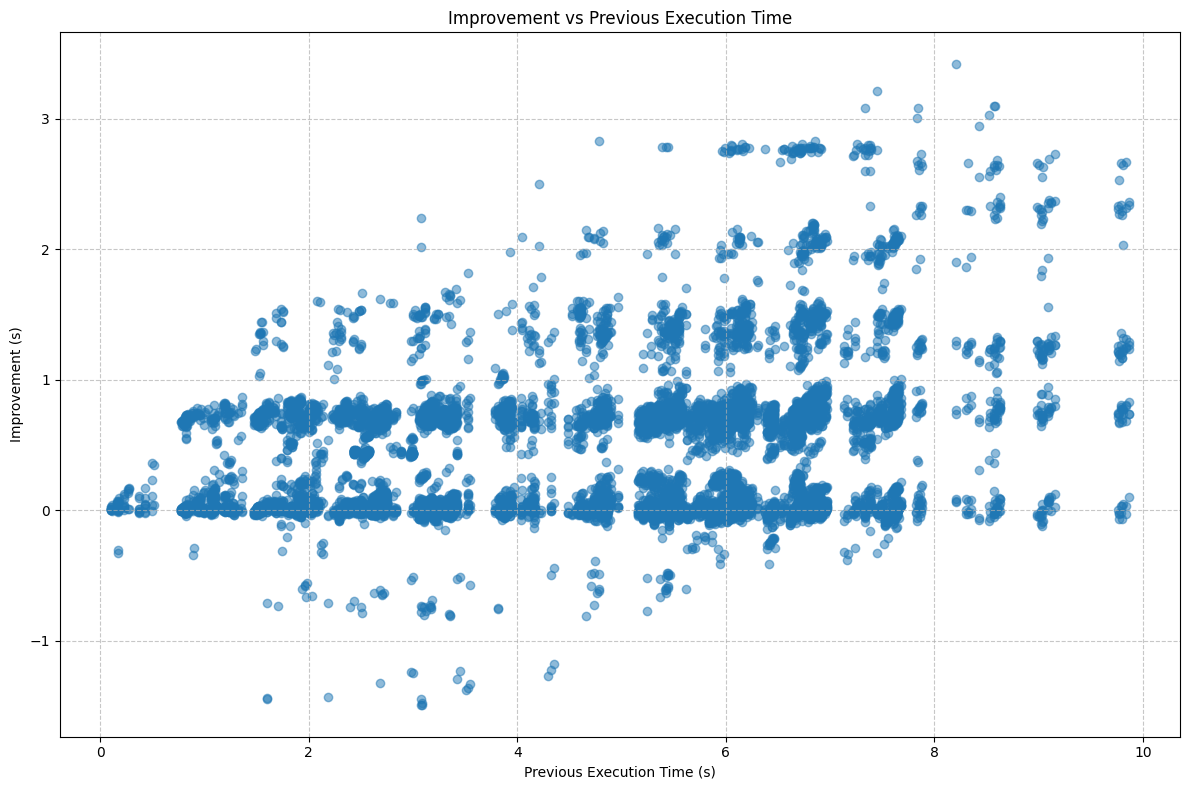

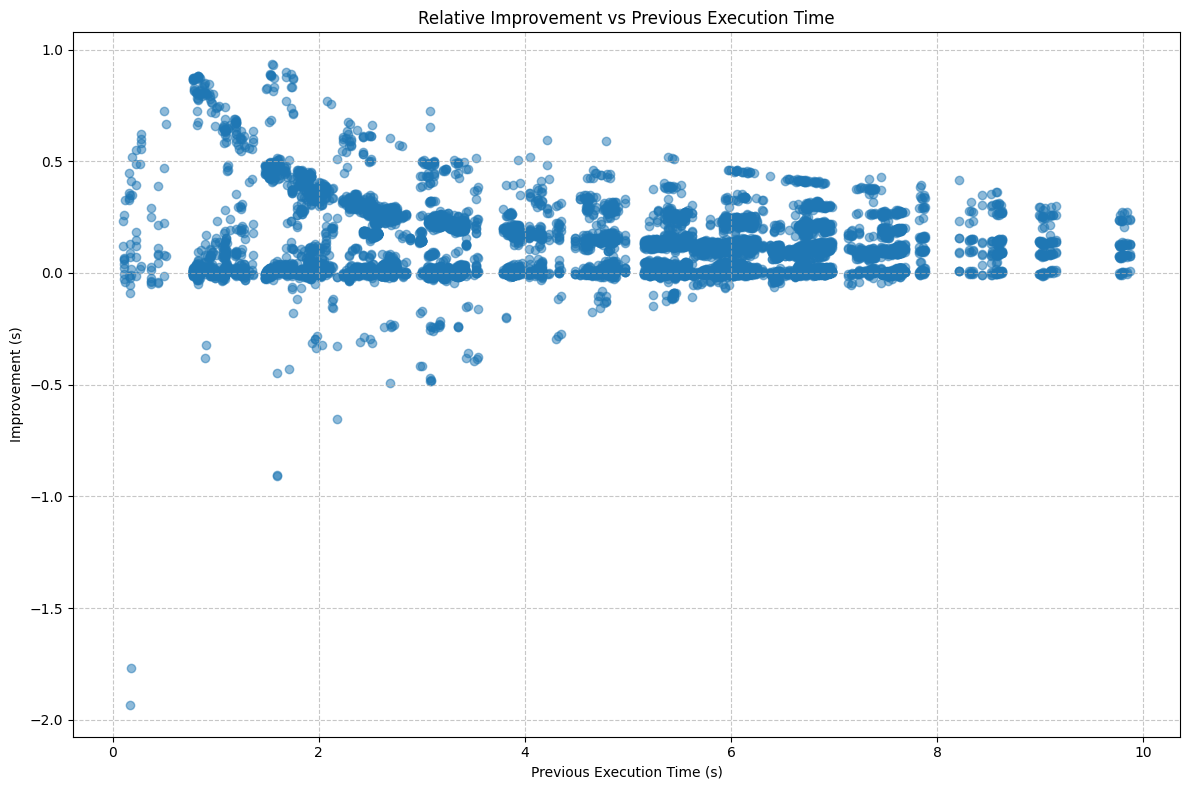

In [6]:
# Create scatter plot
plt.figure(figsize=(12, 8))
plt.scatter( results_df['Previous Time'], results_df['Improvement'], alpha=0.5)

# Add labels and title
plt.xlabel('Previous Execution Time (s)')
plt.ylabel('Improvement (s)')
plt.title('Improvement vs Previous Execution Time')

# Add grid
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()


# Create scatter plot
plt.figure(figsize=(12, 8))
plt.scatter( results_df['Previous Time'], results_df['Relative Improvement'], alpha=0.5)

# Add labels and title
plt.xlabel('Previous Execution Time (s)')
plt.ylabel('Improvement (s)')
plt.title('Relative Improvement vs Previous Execution Time')

# Add grid
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

In [7]:
# Sort by query and time gain, then add rank within each query group
results_df['Query Rank'] = results_df.groupby('Query')['Improvement'].rank(ascending=False).astype(int)

# Calculate percentage rank within each query group (0-100%)
results_df['Query Percentile'] = results_df.groupby('Query')['Improvement'].rank(pct=True).round(2)

In [8]:
# Sort by query and time gain, then add rank within each query group
results_df['Global Rank'] = results_df['Improvement'].rank(ascending=False).astype(int)

# Calculate percentage rank within each query group (0-100%)
results_df['Global Percentile'] = results_df['Improvement'].rank(pct=True).round(2)

results_df['Query Rank'] = results_df.groupby('Query')['Improvement'].rank(ascending=False).astype(int)

results_df['Query Percentile'] = results_df.groupby('Query')['Improvement'].rank(pct=True).round(2)


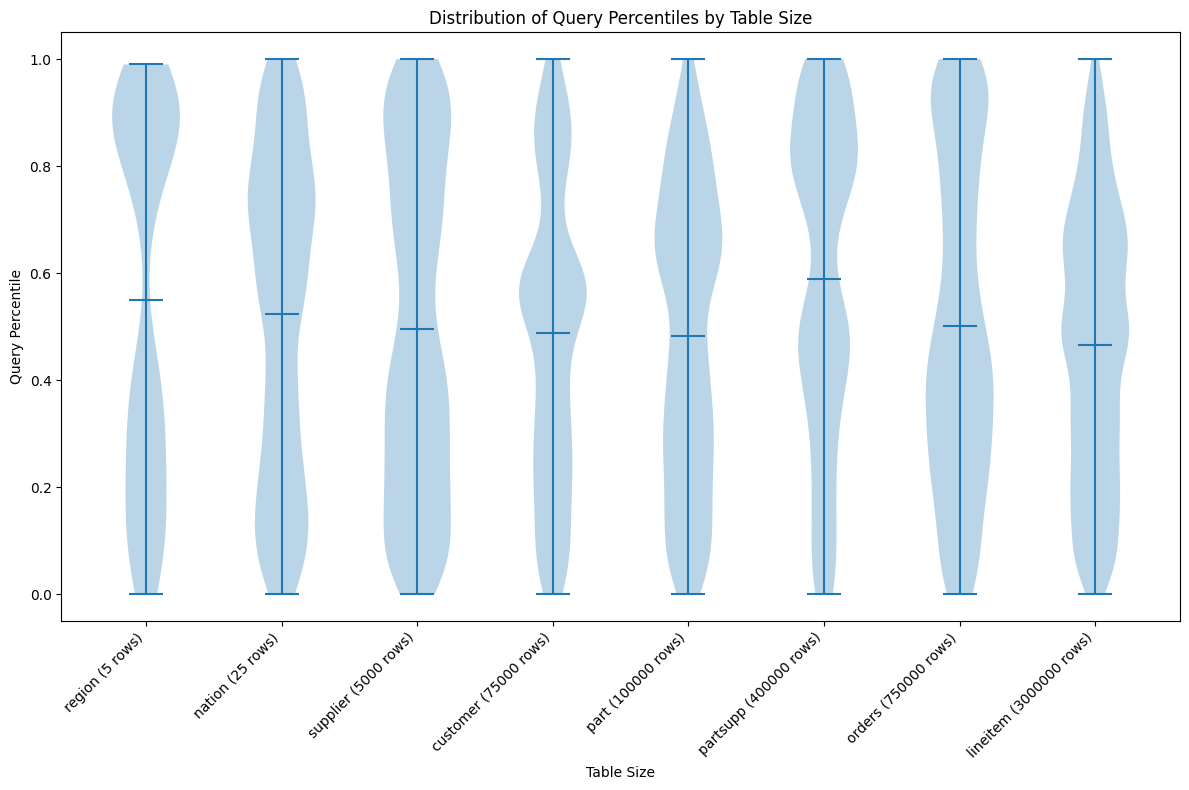

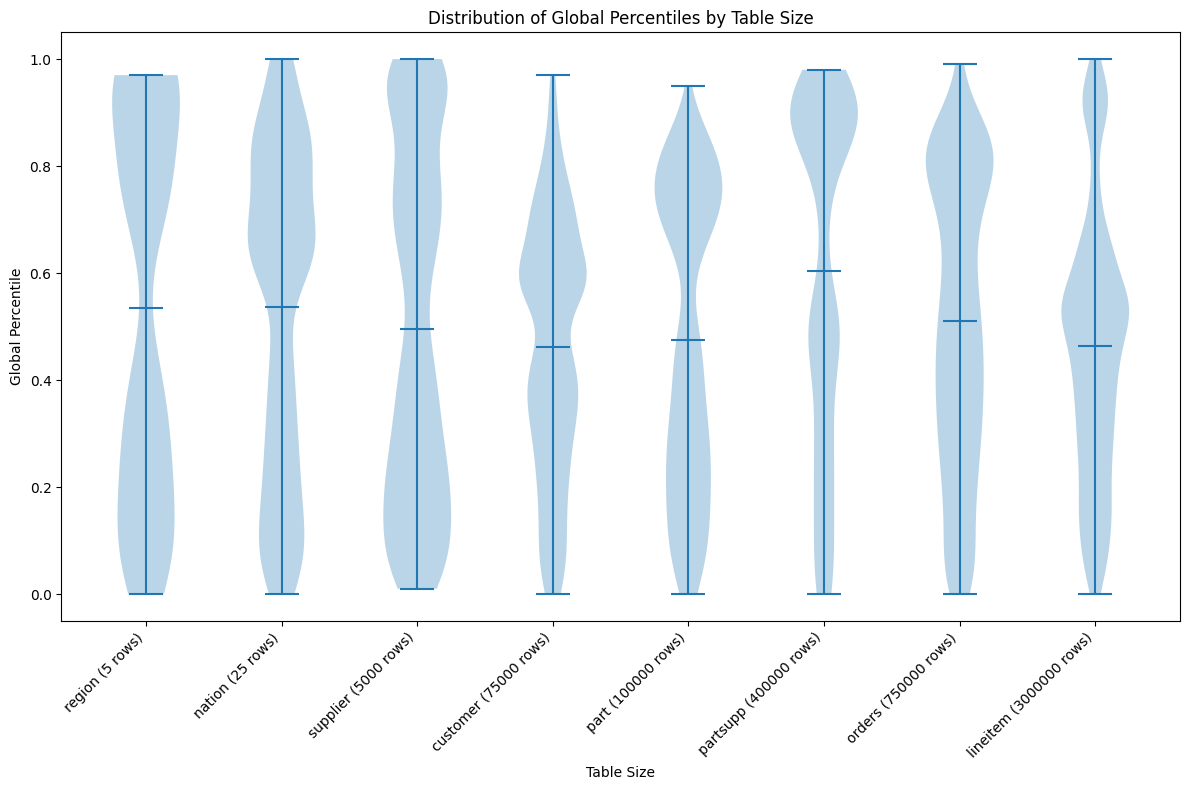

In [9]:
# Sort the dataframe by improvement
results_df.sort_values("Improvement", ascending=False, inplace=True)

# Create categories by table size for Query Percentile
table_size_query_percentiles = {
    'region (5 rows)': results_df[results_df['Table size'] == 5]['Query Percentile'],
    'nation (25 rows)': results_df[results_df['Table size'] == 25]['Query Percentile'], 
    'supplier (5000 rows)': results_df[results_df['Table size'] == 5000]['Query Percentile'],
    'customer (75000 rows)': results_df[results_df['Table size'] == 75000]['Query Percentile'],
    'part (100000 rows)': results_df[results_df['Table size'] == 100000]['Query Percentile'],
    'partsupp (400000 rows)': results_df[results_df['Table size'] == 400000]['Query Percentile'],
    'orders (750000 rows)': results_df[results_df['Table size'] == 750000]['Query Percentile'],
    'lineitem (3000000 rows)': results_df[results_df['Table size'] == 3000000]['Query Percentile']
}

# Create categories by table size for Global Percentile
table_size_global_percentiles = {
    'region (5 rows)': results_df[results_df['Table size'] == 5]['Global Percentile'],
    'nation (25 rows)': results_df[results_df['Table size'] == 25]['Global Percentile'],
    'supplier (5000 rows)': results_df[results_df['Table size'] == 5000]['Global Percentile'], 
    'customer (75000 rows)': results_df[results_df['Table size'] == 75000]['Global Percentile'],
    'part (100000 rows)': results_df[results_df['Table size'] == 100000]['Global Percentile'],
    'partsupp (400000 rows)': results_df[results_df['Table size'] == 400000]['Global Percentile'],
    'orders (750000 rows)': results_df[results_df['Table size'] == 750000]['Global Percentile'],
    'lineitem (3000000 rows)': results_df[results_df['Table size'] == 3000000]['Global Percentile']
}

# Create figure for Query Percentile
plt.figure(figsize=(12, 8))

# Create violin plot for Query Percentile
violin_plot = plt.violinplot(
    list(table_size_query_percentiles.values()),
    showmeans=True
)

# Set x-axis ticks and labels
plt.xticks(
    range(1, len(table_size_query_percentiles) + 1),
    list(table_size_query_percentiles.keys()),
    rotation=45,
    ha='right'
)

# Add labels and title
plt.xlabel('Table Size')
plt.ylabel('Query Percentile')
plt.title('Distribution of Query Percentiles by Table Size')

# Adjust layout
plt.tight_layout()

# Create figure for Global Percentile
plt.figure(figsize=(12, 8))

# Create violin plot for Global Percentile
violin_plot = plt.violinplot(
    list(table_size_global_percentiles.values()),
    showmeans=True
)

# Set x-axis ticks and labels
plt.xticks(
    range(1, len(table_size_global_percentiles) + 1),
    list(table_size_global_percentiles.keys()),
    rotation=45,
    ha='right'
)

# Add labels and title
plt.xlabel('Table Size')
plt.ylabel('Global Percentile')
plt.title('Distribution of Global Percentiles by Table Size')

# Adjust layout
plt.tight_layout()


In [10]:
# Add the datatype of each materialized column from COLUMN_MAP
results_df["Column Type"] = results_df.apply(
    lambda row: tpch_setup.COLUMN_MAP[row["Materialization"]]["type"] 
    if row["Materialization"] in tpch_setup.COLUMN_MAP else "Unknown", 
    axis=1)

results_df

Query Materialization  Execution Time  Previous Time  Improvement  \
5642    q21      l_orderkey        4.791888       8.210625     3.418738   
5549    q21      l_orderkey        4.241371       7.454519     3.213148   
577     q21      l_orderkey        5.472538       8.574982     3.102444   
5561    q21      l_orderkey        5.485127       8.583792     3.098665   
5576    q21      l_orderkey        4.759518       7.845612     3.086095   
...     ...             ...             ...            ...          ...   
13197   q11     ps_availqty        3.045776       1.596690    -1.449086   
2329    q11   ps_supplycost        4.529327       3.078928    -1.450400   
11901   q11   ps_supplycost        4.570223       3.088974    -1.481249   
2307    q11     ps_availqty        4.570017       3.078928    -1.491090   
11868   q11     ps_availqty        4.581160       3.088974    -1.492186   

            Previous Materializations  Table size  Relative Improvement  \
5642       ['l_suppkey', 's_suppkey']     3000000              0.416380   
5549   ['l_suppkey', 'l_receiptdate']     3000000              0.431034   
577                     ['l_suppkey']     3000000              0.361802   
5561     ['l_suppkey', 'n_nationkey']     3000000              0.360990   
5576          ['l_suppkey', 'n_name']     3000000              0.393353   
...                               ...         ...                   ...   
13197       ['n_name', 's_nationkey']      400000             -0.907557   
2329                  ['s_nationkey']      400000             -0.471073   
11901  ['n_nationkey', 's_nationkey']      400000             -0.479528   
2307                  ['s_nationkey']      400000             -0.484289   
11868  ['n_nationkey', 's_nationkey']      400000             -0.483068   

       Query Rank  Query Percentile  Global Rank  Global Percentile  \
5642            1              1.00            1                1.0   
5549            2              1.00            2                1.0   
577             3              1.00            3                1.0   
5561            4              1.00            4                1.0   
5576            5              0.99            5                1.0   
...           ...               ...          ...                ...   
13197         228              0.02        16165                0.0   
2329          229              0.02        16166                0.0   
11901         230              0.01        16167                0.0   
2307          231              0.01        16168                0.0   
11868         232              0.00        16169                0.0   

      Column Type  
5642          INT  
5549          INT  
577           INT  
5561          INT  
5576          INT  
...           ...  
13197         INT  
2329          INT  
11901         INT  
2307          INT  
11868         INT  

[16169 rows x 13 columns]

In [11]:
def get_field_frequency_for_query(query_name, materialized_column):
    q = queries[query_name]
    cols = q.columns_used()
    return cols.count(materialized_column)

def get_field_join_frequency_for_query(query_name, materialized_column):
    q = queries[query_name]
    cols = q.columns_used_in_join()
    if materialized_column in cols:
        return len(cols[materialized_column])
    else:
        return 0


def get_field_where_frequency_for_query(query_name, materialized_column):
    q = queries[query_name]
    cols = q.columns_used_with_position()["where"]
    return cols.count(materialized_column)

def get_field_select_frequency_for_query(query_name, materialized_column):
    q = queries[query_name]
    cols = q.columns_used_with_position()["select"]
    return cols.count(materialized_column)

def get_field_group_by_frequency_for_query(query_name, materialized_column):
    q = queries[query_name]
    cols = q.columns_used_with_position()["group_by"]
    return cols.count(materialized_column)

def get_field_order_by_frequency_for_query(query_name, materialized_column):
    q = queries[query_name]
    cols = q.columns_used_with_position()["order_by"]
    return cols.count(materialized_column)

def get_self_join_frequency_for_query(query_name, materialized_column):
    q = queries[query_name]
    cols = q.columns_used_with_position()
    if "self_join" in cols and materialized_column in cols["self_join"].keys():
        return cols["self_join"][materialized_column]
    return 0



queries = tpch_setup.QUERIES

results_df["Total Frequency"] = results_df.apply(
    lambda row: get_field_frequency_for_query(row["Query"], row["Materialization"]), axis=1
)

results_df["Join Frequency"] = results_df.apply(
    lambda row: get_field_join_frequency_for_query(row["Query"], row["Materialization"]), axis=1
)

results_df["Where Frequency"] = results_df.apply(
    lambda row: get_field_where_frequency_for_query(row["Query"], row["Materialization"]), axis=1
)

results_df["Select Frequency"] = results_df.apply(
    lambda row: get_field_select_frequency_for_query(row["Query"], row["Materialization"]), axis=1
)
results_df["Group By Frequency"] = results_df.apply(
    lambda row: get_field_group_by_frequency_for_query(row["Query"], row["Materialization"]), axis=1
)
results_df["Order By Frequency"] = results_df.apply(
    lambda row: get_field_order_by_frequency_for_query(row["Query"], row["Materialization"]), axis=1
)

results_df["Self Join Frequency"] = results_df.apply(
    lambda row: get_self_join_frequency_for_query(row["Query"], row["Materialization"]), axis=1
)


In [12]:
results_df[(results_df["Select Frequency"] == 1) & (results_df["Where Frequency"] == 0) & (results_df["Join Frequency"] == 1)].head(50)

Query Materialization  Execution Time  Previous Time  Improvement  \
4713    q18      l_orderkey        2.443687       4.154700     1.711014   
2913    q18      l_orderkey        1.710876       3.410222     1.699346   
6416    q18      l_orderkey        1.641986       3.311369     1.669384   
5669    q18      l_orderkey        0.844736       2.513315     1.668578   
6347    q18      l_orderkey        1.689167       3.346678     1.657511   
6395    q18      l_orderkey        1.703375       3.354979     1.651604   
685     q18      l_orderkey        1.707222       3.350993     1.643771   
5666    q18      l_orderkey        1.066033       2.686599     1.620566   
5660    q18      l_orderkey        1.838199       3.448740     1.610541   
3518    q13       c_custkey        0.477427       2.083188     1.605762   
321     q13       c_custkey        0.517631       2.113497     1.595866   
4677    q18      l_orderkey        3.096013       4.690016     1.594003   
4       q13       c_custkey        1.216612       2.806873     1.590261   
303     q13       c_custkey        1.192361       2.782430     1.590069   
5663    q18      l_orderkey        1.836267       3.425930     1.589663   
2811    q18      l_orderkey        2.366912       3.949556     1.582644   
579     q18      l_orderkey        3.081731       4.660657     1.578926   
3512    q13       c_custkey        0.768908       2.300611     1.531703   
317     q13       c_custkey        0.856483       2.372505     1.516023   
3545    q13       c_custkey        0.171845       1.684944     1.513099   
11408    q8     n_nationkey        4.536104       5.999410     1.463305   
11126    q8     n_nationkey        5.211629       6.666482     1.454852   
14907    q2      ps_suppkey        4.698744       6.152119     1.453374   
2281     q2      ps_suppkey        5.456521       6.898909     1.442387   
9381     q8     n_nationkey        5.218698       6.655872     1.437174   
11384    q8     n_nationkey        5.234468       6.670287     1.435819   
8064     q8     n_nationkey        5.250050       6.675880     1.425830   
15111    q2      ps_suppkey        5.493015       6.916174     1.423158   
1525     q8     n_nationkey        5.244817       6.665676     1.420859   
11294    q8     n_nationkey        4.501339       5.920146     1.418807   
4224     q8     n_nationkey        4.688547       6.102421     1.413874   
11402    q8     n_nationkey        4.494804       5.907767     1.412962   
9993     q8     n_nationkey        5.255219       6.666737     1.411518   
13161    q2      ps_suppkey        5.497085       6.908598     1.411513   
11399    q8     n_nationkey        5.264365       6.663789     1.399425   
12453    q2      ps_suppkey        4.002196       5.399703     1.397507   
15614    q2      ps_suppkey        5.480047       6.877034     1.396987   
3333     q8     n_nationkey        4.650330       6.046932     1.396602   
14052    q2      ps_suppkey        4.796609       6.188250     1.391641   
11423    q8     n_nationkey        5.282595       6.670306     1.387711   
14577    q2      ps_suppkey        5.510835       6.886097     1.375262   
11378    q8     n_nationkey        4.546583       5.921277     1.374694   
15635    q2      ps_suppkey        4.003555       5.377623     1.374068   
655     q18      l_orderkey        2.984109       4.353260     1.369151   
669     q18      l_orderkey        2.180918       3.543470     1.362553   
7128     q8     n_nationkey        4.556193       5.898942     1.342750   
2626    q18      l_orderkey        3.483482       4.817088     1.333606   
657     q18      l_orderkey        3.002899       4.324564     1.321665   
238     q18      l_orderkey        3.529692       4.846286     1.316594   
4698    q18      l_orderkey        4.225875       5.533894     1.308018   

               Previous Materializations  Table size  Relative Improvement  \
4713            ['c_name', 'o_orderkey']     3000000              0.411826   
2913         ['c_custkey

In [13]:


# Create scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(results_df_negative_improvement['Previous Time'], results_df_negative_improvement['Improvement'], 
           c=results_df_negative_improvement['Materialization'].astype('category').cat.codes, 
           alpha=0.5, cmap='tab20')

# Add labels and title
plt.xlabel('Previous Execution Time (s)')
plt.ylabel('Improvement (s)')
plt.title('Improvement vs Previous Execution Time')

# Add colorbar legend
colorbar = plt.colorbar()
colorbar.set_ticks(range(len(results_df_negative_improvement['Materialization'].unique())))
colorbar.set_ticklabels(sorted(results_df_negative_improvement['Materialization'].unique()))

# Add grid
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()


# Create scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(results_df_negative_improvement['Previous Time'], results_df_negative_improvement['Relative Improvement'],
           c=results_df_negative_improvement['Materialization'].astype('category').cat.codes,
           alpha=0.5, cmap='tab20')

# Add labels and title
plt.xlabel('Previous Execution Time (s)')
plt.ylabel('Improvement (s)')
plt.title('Relative Improvement vs Previous Execution Time')

# Add colorbar legend
colorbar = plt.colorbar()
colorbar.set_ticks(range(len(results_df_negative_improvement['Materialization'].unique())))
colorbar.set_ticklabels(sorted(results_df_negative_improvement['Materialization'].unique()))

# Add grid
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

NameError: name 'results_df_negative_improvement' is not defined

<Figure size 1200x800 with 0 Axes>

In [1782]:
# Sort by query and time gain, then add rank within each query group
results_df['Query Rank'] = results_df.groupby('Query')['Improvement'].rank(ascending=False).astype(int)

# Calculate percentage rank within each query group (0-100%)
results_df['Query Percentile'] = results_df.groupby('Query')['Improvement'].rank(pct=True).round(2)



# Sort by query and time gain, then add rank within each query group
results_df['Global Rank'] = results_df['Improvement'].rank(ascending=False).astype(int)

# Calculate percentage rank within each query group (0-100%)
results_df['Global Percentile'] = results_df['Improvement'].rank(pct=True).round(2)

results_df['Query Rank'] = results_df.groupby('Query')['Improvement'].rank(ascending=False).astype(int)

results_df['Query Percentile'] = results_df.groupby('Query')['Improvement'].rank(pct=True).round(2)





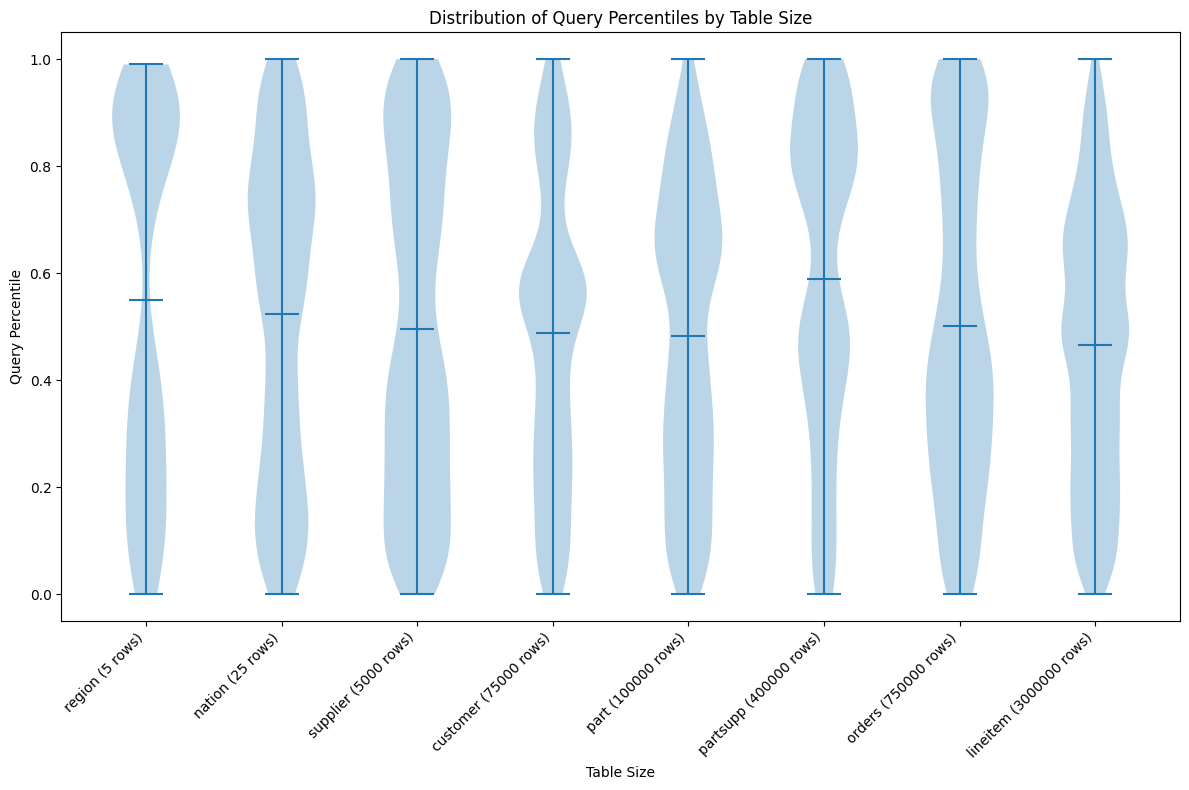

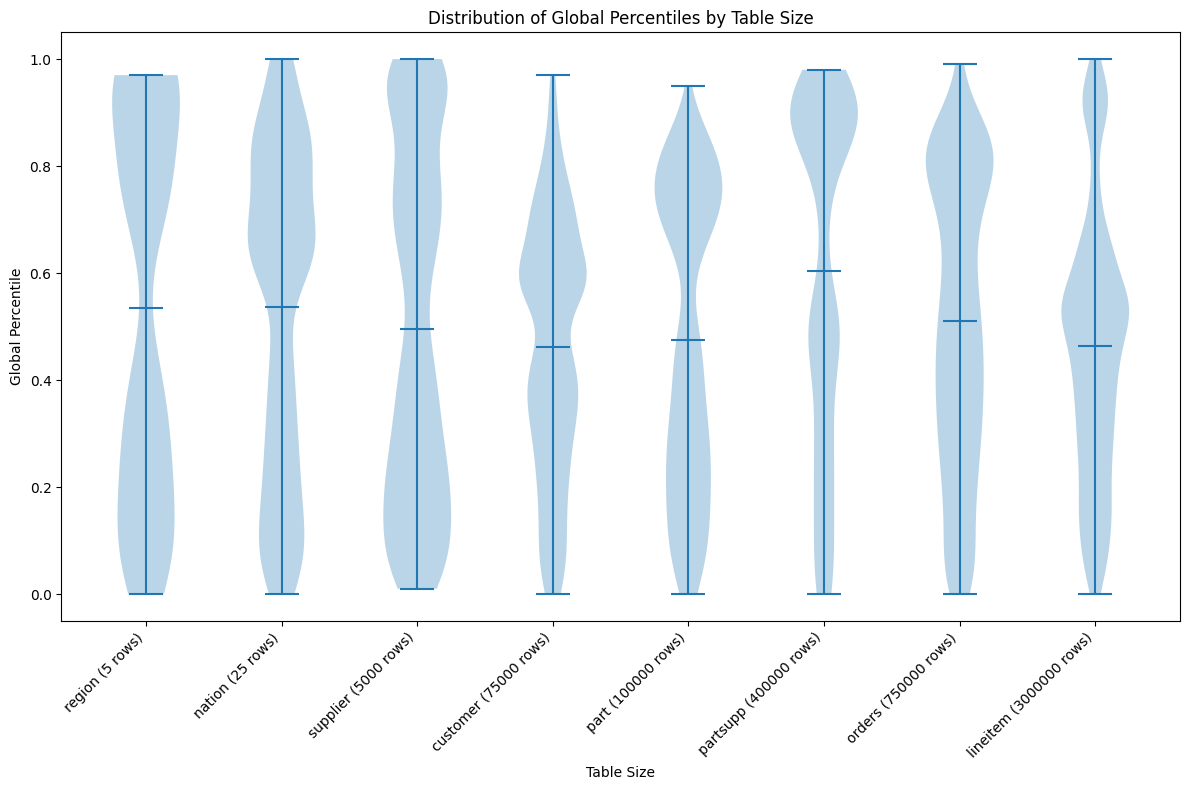

In [1783]:
# Sort the dataframe by improvement
results_df.sort_values("Improvement", ascending=False, inplace=True)

# Create categories by table size for Query Percentile
table_size_query_percentiles = {
    'region (5 rows)': results_df[results_df['Table size'] == 5]['Query Percentile'],
    'nation (25 rows)': results_df[results_df['Table size'] == 25]['Query Percentile'], 
    'supplier (5000 rows)': results_df[results_df['Table size'] == 5000]['Query Percentile'],
    'customer (75000 rows)': results_df[results_df['Table size'] == 75000]['Query Percentile'],
    'part (100000 rows)': results_df[results_df['Table size'] == 100000]['Query Percentile'],
    'partsupp (400000 rows)': results_df[results_df['Table size'] == 400000]['Query Percentile'],
    'orders (750000 rows)': results_df[results_df['Table size'] == 750000]['Query Percentile'],
    'lineitem (3000000 rows)': results_df[results_df['Table size'] == 3000000]['Query Percentile']
}

# Create categories by table size for Global Percentile
table_size_global_percentiles = {
    'region (5 rows)': results_df[results_df['Table size'] == 5]['Global Percentile'],
    'nation (25 rows)': results_df[results_df['Table size'] == 25]['Global Percentile'],
    'supplier (5000 rows)': results_df[results_df['Table size'] == 5000]['Global Percentile'], 
    'customer (75000 rows)': results_df[results_df['Table size'] == 75000]['Global Percentile'],
    'part (100000 rows)': results_df[results_df['Table size'] == 100000]['Global Percentile'],
    'partsupp (400000 rows)': results_df[results_df['Table size'] == 400000]['Global Percentile'],
    'orders (750000 rows)': results_df[results_df['Table size'] == 750000]['Global Percentile'],
    'lineitem (3000000 rows)': results_df[results_df['Table size'] == 3000000]['Global Percentile']
}

# Create figure for Query Percentile
plt.figure(figsize=(12, 8))

# Create violin plot for Query Percentile
violin_plot = plt.violinplot(
    list(table_size_query_percentiles.values()),
    showmeans=True
)

# Set x-axis ticks and labels
plt.xticks(
    range(1, len(table_size_query_percentiles) + 1),
    list(table_size_query_percentiles.keys()),
    rotation=45,
    ha='right'
)

# Add labels and title
plt.xlabel('Table Size')
plt.ylabel('Query Percentile')
plt.title('Distribution of Query Percentiles by Table Size')

# Adjust layout
plt.tight_layout()

# Create figure for Global Percentile
plt.figure(figsize=(12, 8))

# Create violin plot for Global Percentile
violin_plot = plt.violinplot(
    list(table_size_global_percentiles.values()),
    showmeans=True
)

# Set x-axis ticks and labels
plt.xticks(
    range(1, len(table_size_global_percentiles) + 1),
    list(table_size_global_percentiles.keys()),
    rotation=45,
    ha='right'
)

# Add labels and title
plt.xlabel('Table Size')
plt.ylabel('Global Percentile')
plt.title('Distribution of Global Percentiles by Table Size')

# Adjust layout
plt.tight_layout()


In [1784]:
# Add the datatype of each materialized column from COLUMN_MAP
results_df["Column Type"] = results_df.apply(
    lambda row: tpch_setup.COLUMN_MAP[row["Materialization"]]["type"] 
    if row["Materialization"] in tpch_setup.COLUMN_MAP else "Unknown", 
    axis=1)

results_df

Query Materialization  Execution Time  Previous Time  Improvement  \
5642    q21      l_orderkey        4.791888       8.210625     3.418738   
5549    q21      l_orderkey        4.241371       7.454519     3.213148   
577     q21      l_orderkey        5.472538       8.574982     3.102444   
5561    q21      l_orderkey        5.485127       8.583792     3.098665   
5576    q21      l_orderkey        4.759518       7.845612     3.086095   
...     ...             ...             ...            ...          ...   
13197   q11     ps_availqty        3.045776       1.596690    -1.449086   
2329    q11   ps_supplycost        4.529327       3.078928    -1.450400   
11901   q11   ps_supplycost        4.570223       3.088974    -1.481249   
2307    q11     ps_availqty        4.570017       3.078928    -1.491090   
11868   q11     ps_availqty        4.581160       3.088974    -1.492186   

            Previous Materializations  Table size  Relative Improvement  \
5642       ['l_suppkey', 's_suppkey']     3000000              0.416380   
5549   ['l_suppkey', 'l_receiptdate']     3000000              0.431034   
577                     ['l_suppkey']     3000000              0.361802   
5561     ['l_suppkey', 'n_nationkey']     3000000              0.360990   
5576          ['l_suppkey', 'n_name']     3000000              0.393353   
...                               ...         ...                   ...   
13197       ['n_name', 's_nationkey']      400000             -0.907557   
2329                  ['s_nationkey']      400000             -0.471073   
11901  ['n_nationkey', 's_nationkey']      400000             -0.479528   
2307                  ['s_nationkey']      400000             -0.484289   
11868  ['n_nationkey', 's_nationkey']      400000             -0.483068   

       Query Rank  Query Percentile  Global Rank  Global Percentile  \
5642            1              1.00            1                1.0   
5549            2              1.00            2                1.0   
577             3              1.00            3                1.0   
5561            4              1.00            4                1.0   
5576            5              0.99            5                1.0   
...           ...               ...          ...                ...   
13197         228              0.02        16165                0.0   
2329          229              0.02        16166                0.0   
11901         230              0.01        16167                0.0   
2307          231              0.01        16168                0.0   
11868         232              0.00        16169                0.0   

      Column Type  Total Frequency  Join Frequency  Where Frequency  \
5642          INT                5               1                0   
5549          INT                5               1                0   
577           INT                5               1                0   
5561          INT                5               1                0   
5576          INT                5               1                0   
...           ...              ...             ...              ...   
13197         INT                3               0                1   
2329          INT                3               0                1   
11901         INT                3               0                1   
2307          INT                3               0                1   
11868         INT                3               0                1   

       Select Frequency  Group By Frequency  Order By Frequency  \
5642                  0                   0                   0   
5549                  0                   0                   0   
577                   0                   0                   0   
5561                  0                   0                   0   
5576                  0                   0                   0   
...                 ...                 ...                 ...   
13197                 2      

In [1785]:
def get_field_frequency_for_query(query_name, materialized_column):
    q = queries[query_name]
    cols = q.columns_used()
    return cols.count(materialized_column)

def get_field_join_frequency_for_query(query_name, materialized_column):
    q = queries[query_name]
    cols = q.columns_used_in_join()
    if materialized_column in cols:
        return len(cols[materialized_column])
    else:
        return 0


def get_field_where_frequency_for_query(query_name, materialized_column):
    q = queries[query_name]
    cols = q.columns_used_with_position()["where"]
    return cols.count(materialized_column)

def get_field_select_frequency_for_query(query_name, materialized_column):
    q = queries[query_name]
    cols = q.columns_used_with_position()["select"]
    return cols.count(materialized_column)

def get_field_group_by_frequency_for_query(query_name, materialized_column):
    q = queries[query_name]
    cols = q.columns_used_with_position()["group_by"]
    return cols.count(materialized_column)

def get_field_order_by_frequency_for_query(query_name, materialized_column):
    q = queries[query_name]
    cols = q.columns_used_with_position()["order_by"]
    return cols.count(materialized_column)

def get_self_join_frequency_for_query(query_name, materialized_column):
    q = queries[query_name]
    cols = q.columns_used_with_position()
    if "self_join" in cols and materialized_column in cols["self_join"].keys():
        return cols["self_join"][materialized_column]
    return 0



queries = tpch_setup.QUERIES

results_df["Total Frequency"] = results_df.apply(
    lambda row: get_field_frequency_for_query(row["Query"], row["Materialization"]), axis=1
)

results_df["Join Frequency"] = results_df.apply(
    lambda row: get_field_join_frequency_for_query(row["Query"], row["Materialization"]), axis=1
)

results_df["Where Frequency"] = results_df.apply(
    lambda row: get_field_where_frequency_for_query(row["Query"], row["Materialization"]), axis=1
)

results_df["Select Frequency"] = results_df.apply(
    lambda row: get_field_select_frequency_for_query(row["Query"], row["Materialization"]), axis=1
)
results_df["Group By Frequency"] = results_df.apply(
    lambda row: get_field_group_by_frequency_for_query(row["Query"], row["Materialization"]), axis=1
)
results_df["Order By Frequency"] = results_df.apply(
    lambda row: get_field_order_by_frequency_for_query(row["Query"], row["Materialization"]), axis=1
)

results_df["Self Join Frequency"] = results_df.apply(
    lambda row: get_self_join_frequency_for_query(row["Query"], row["Materialization"]), axis=1
)


In [17]:
results_df[(results_df["Query"] == "q17") & (results_df["Materialization"] == "p_brand")]


Query Materialization  Execution Time  Previous Time  Improvement  \
7483    q17         p_brand        0.484307       1.236141     0.751835   
8950    q17         p_brand        1.546304       2.282060     0.735756   
9730    q17         p_brand        1.539704       2.270767     0.731063   
1168    q17         p_brand        1.537656       2.263085     0.725429   
8725    q17         p_brand        1.561095       2.285850     0.724756   
6907    q17         p_brand        0.176335       0.900855     0.724520   
6796    q17         p_brand        0.102794       0.824829     0.722035   
1038    q17         p_brand        1.546845       2.268317     0.721472   
816     q17         p_brand        0.175105       0.895660     0.720555   
2044    q17         p_brand        1.535217       2.245207     0.709990   
154     q17         p_brand        1.529594       2.238931     0.709337   
14448   q17         p_brand        1.512252       1.520165     0.007914   
8988    q17         p_brand        1.545872       1.550815     0.004942   
7548    q17         p_brand        0.172322       0.168813    -0.003509   
9774    q17         p_brand        1.544446       1.538820    -0.005626   
2179    q17         p_brand        1.537862       1.521387    -0.016475   

                Previous Materializations  Table size  Relative Improvement  \
7483           ['l_partkey', 'p_partkey']      100000              0.608211   
8950          ['l_quantity', 'p_partkey']      100000              0.322409   
9730     ['l_extendedprice', 'p_partkey']      100000              0.321945   
1168                  ['l_extendedprice']      100000              0.320549   
8725    ['l_quantity', 'l_extendedprice']      100000              0.317062   
6907     ['l_partkey', 'l_extendedprice']      100000              0.804258   
6796          ['l_partkey', 'l_quantity']      100000              0.875375   
1038                       ['l_quantity']      100000              0.318065   
816                         ['l_partkey']      100000              0.804496   
2044                        ['p_partkey']      100000              0.316225   
154                                    []      100000              0.316819   
14448        ['p_partkey', 'p_container']      100000              0.005206   
8988        ['l_quantity', 'p_container']      100000              0.003187   
7548         ['l_partkey', 'p_container']      100000             -0.020787   
9774   ['l_extendedprice', 'p_container']      100000             -0.003656   
2179                      ['p_container']      100000             -0.010829   

       Query Rank  Query Percentile  Global Rank  Global Percentile  \
7483           17              0.83         3308               0.80   
8950           20              0.80         3895               0.76   
9730           21              0.79         4090               0.75   
1168           24              0.76         4268               0.74   
8725           26              0.74         4292               0.73   
6907           27              0.73         4302               0.73   
6796           29              0.71         4377               0.73   
1038           31              0.69         4398               0.73   
816            32              0.68         4422               0.73   
2044           37              0.62         4726               0.71   
154            38              0.61         4748               0.71   
14448          51              0.48        11900               0.26   
8988           52              0.47        12236               0.24   
7548           61              0.38        13207               0.18   
9774           65              0.33        13425               0.17   
2179           78              0.20        14421               0.11   

      Column Type  Total Frequency  Join Frequency  Where Frequency  \
7483      VARCHAR                1               0                1   
8950      VARCHAR                1  

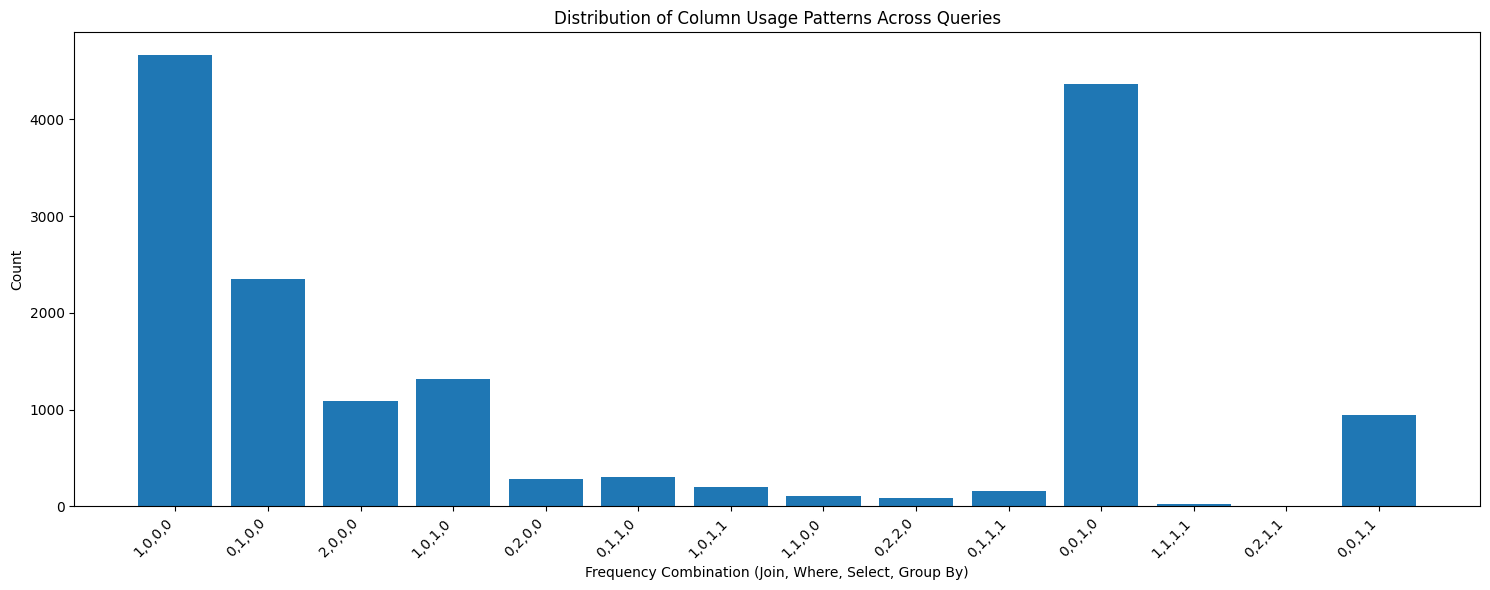

In [1787]:
import matplotlib.pyplot as plt
import pandas as pd

percentile = 0.8

# --- 1. Compute filtered counts for Query Percentile ---
filtered_results_df_query = results_df[results_df["Query Percentile"] >= percentile]
filtered_counts_df_query = (
    filtered_results_df_query
    .groupby(["Join Frequency", "Where Frequency", "Select Frequency", "Group By Frequency"])
    .size()
    .reset_index(name='FilteredCount')
)

# --- 2. Compute filtered counts for Global Percentile ---
filtered_results_df_global = results_df[results_df["Global Percentile"] >= percentile]
filtered_counts_df_global = (
    filtered_results_df_global
    .groupby(["Join Frequency", "Where Frequency", "Select Frequency", "Group By Frequency"])
    .size()
    .reset_index(name='FilteredCount')
)

# --- 3. Compute unfiltered counts ---
unfiltered_counts_df = (
    results_df
    .groupby(["Join Frequency", "Where Frequency", "Select Frequency", "Group By Frequency"])
    .size()
    .reset_index(name='TotalCount')
)

# --- 4. Merge and compute normalization for Query Percentile ---
counts_df_query = pd.merge(
    filtered_counts_df_query,
    unfiltered_counts_df,
    on=["Join Frequency", "Where Frequency", "Select Frequency", "Group By Frequency"],
    how="inner"
)
counts_df_query['Label'] = counts_df_query.apply(
    lambda row: f"{row['Join Frequency']},{row['Where Frequency']},{row['Select Frequency']},{row['Group By Frequency']}",
    axis=1
)
counts_df_query['Normalized'] = counts_df_query['FilteredCount'] / counts_df_query['TotalCount']
counts_df_query = counts_df_query.sort_values('FilteredCount', ascending=False)

# --- 5. Merge and compute normalization for Global Percentile ---
counts_df_global = pd.merge(
    filtered_counts_df_global,
    unfiltered_counts_df,
    on=["Join Frequency", "Where Frequency", "Select Frequency", "Group By Frequency"],
    how="inner"
)
counts_df_global['Label'] = counts_df_global.apply(
    lambda row: f"{row['Join Frequency']},{row['Where Frequency']},{row['Select Frequency']},{row['Group By Frequency']}",
    axis=1
)
counts_df_global['Normalized'] = counts_df_global['FilteredCount'] / counts_df_global['TotalCount']

# Reorder global percentile dataframe to match query percentile order
counts_df_global = counts_df_global.set_index('Label').reindex(counts_df_query['Label']).reset_index()

# Create bar plot
plt.figure(figsize=(15, 6))
plt.bar(counts_df_global['Label'], counts_df_global['TotalCount'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Frequency Combination (Join, Where, Select, Group By)')
plt.ylabel('Count')
plt.title('Distribution of Column Usage Patterns Across Queries')
plt.tight_layout()
plt.show()

/var/folders/6s/wqp33w8x1s79241ysd40kr500000gn/T/ipykernel_29052/1547315940.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0,0].set_xticklabels(counts_df_query['Label'], rotation=45, ha='right')
/var/folders/6s/wqp33w8x1s79241ysd40kr500000gn/T/ipykernel_29052/1547315940.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0,1].set_xticklabels(counts_df_query['Label'], rotation=45, ha='right')
/var/folders/6s/wqp33w8x1s79241ysd40kr500000gn/T/ipykernel_29052/1547315940.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1,0].set_xticklabels(counts_df_global['Label'], rotation=45, ha='right')
/var/folders/6s/wqp33w8x1s79241ysd40kr500000gn/T/ipykernel_29052/1547315940.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1,1].set_xticklabels(counts_df_global['Label'], rotation=45, ha='right')


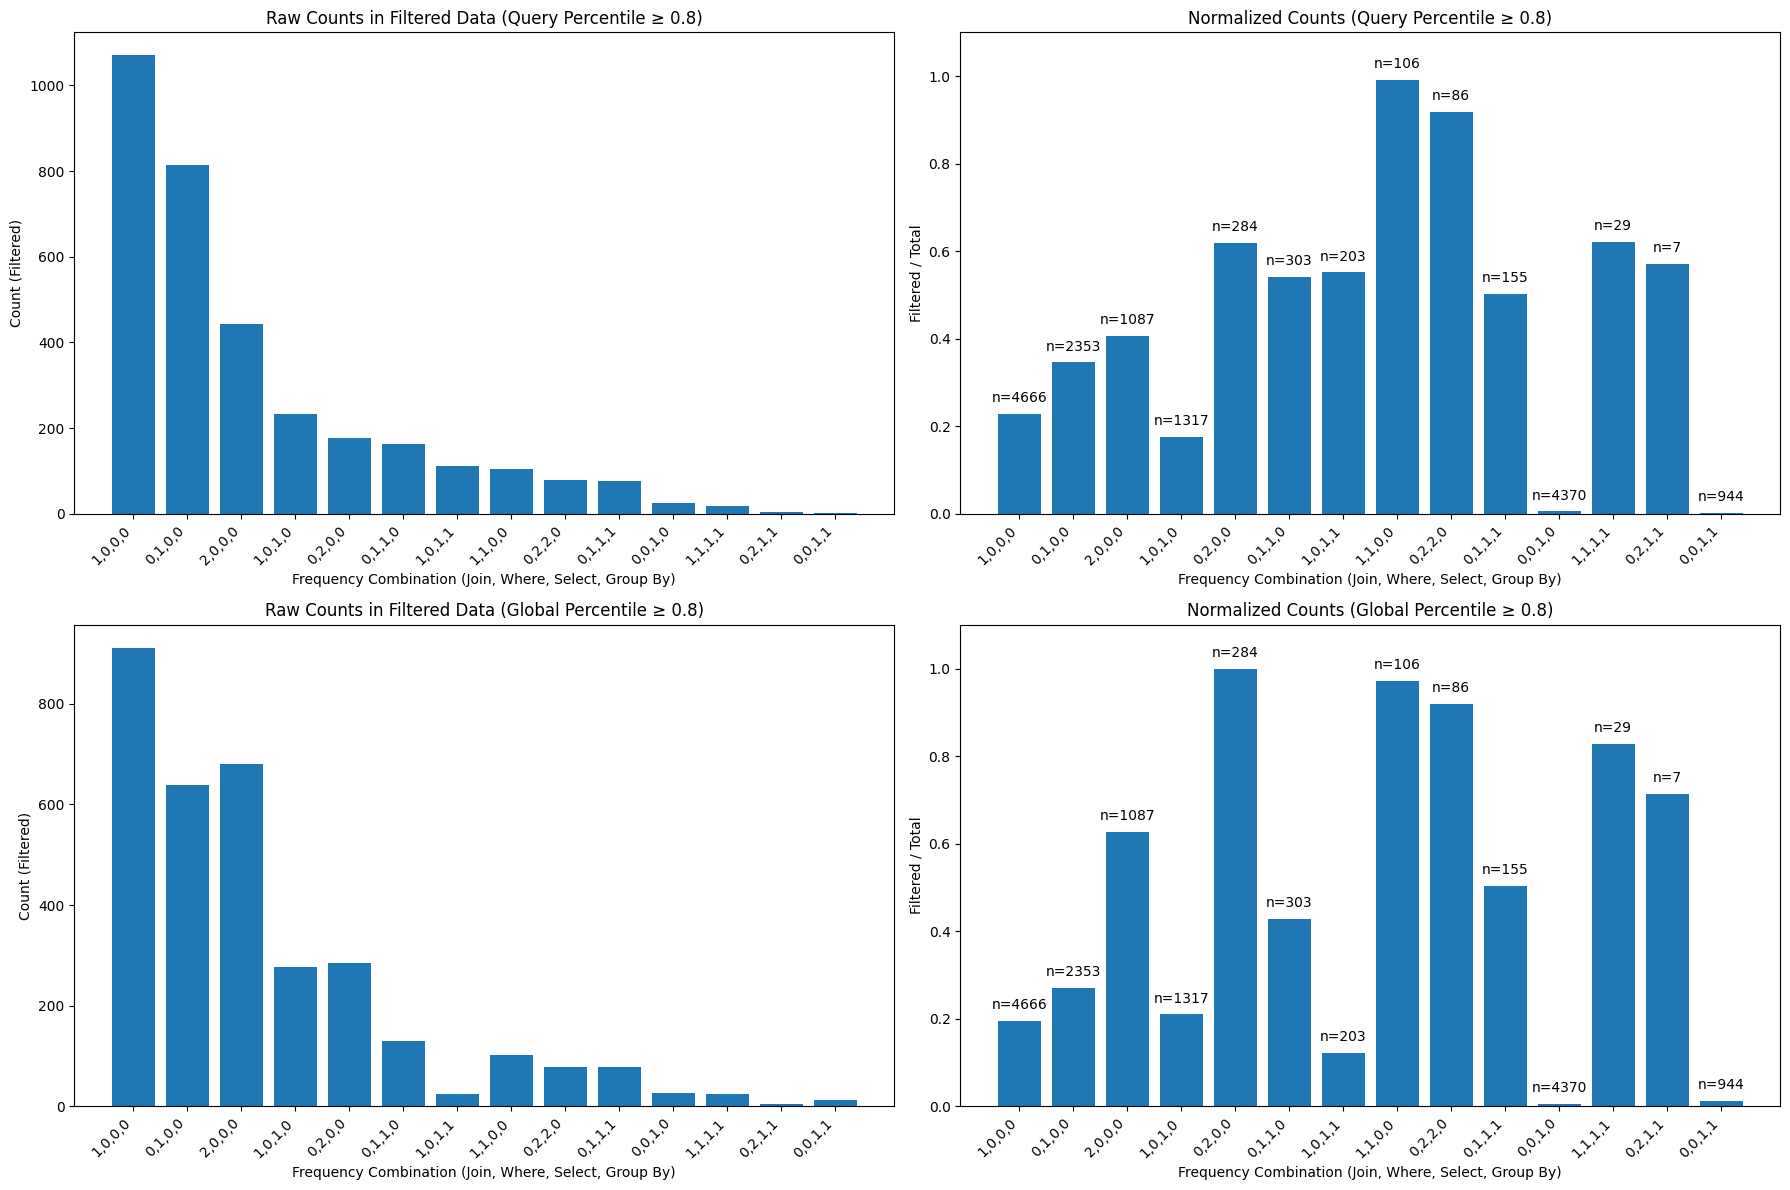

In [1788]:
# --- 6. Create plots ---
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))

# Helper to annotate total counts above normalized bars
def _annotate_total_counts(ax, totals):
    for i, p in enumerate(ax.patches):
        total = int(totals.iloc[i])
        ax.text(
            p.get_x() + p.get_width() / 2.,
            p.get_height() + 0.02,
            f'n={total}', ha='center', va='bottom'
        )

# Query Percentile plots
axes[0,0].bar(counts_df_query['Label'], counts_df_query['FilteredCount'])
axes[0,0].set_xticklabels(counts_df_query['Label'], rotation=45, ha='right')
axes[0,0].set_xlabel('Frequency Combination (Join, Where, Select, Group By)')
axes[0,0].set_ylabel('Count (Filtered)')
axes[0,0].set_title(f'Raw Counts in Filtered Data (Query Percentile ≥ {percentile})')

axes[0,1].bar(counts_df_query['Label'], counts_df_query['Normalized'])
axes[0,1].set_xticklabels(counts_df_query['Label'], rotation=45, ha='right')
axes[0,1].set_xlabel('Frequency Combination (Join, Where, Select, Group By)')
axes[0,1].set_ylabel('Filtered / Total')
axes[0,1].set_title(f'Normalized Counts (Query Percentile ≥ {percentile})')
axes[0,1].set_ylim(0, 1.1)  # space for annotations
# Annotate using total counts
_annotate_total_counts(axes[0,1], counts_df_query['TotalCount'])

# Global Percentile plots
axes[1,0].bar(counts_df_global['Label'], counts_df_global['FilteredCount'])
axes[1,0].set_xticklabels(counts_df_global['Label'], rotation=45, ha='right')
axes[1,0].set_xlabel('Frequency Combination (Join, Where, Select, Group By)')
axes[1,0].set_ylabel('Count (Filtered)')
axes[1,0].set_title(f'Raw Counts in Filtered Data (Global Percentile ≥ {percentile})')

axes[1,1].bar(counts_df_global['Label'], counts_df_global['Normalized'])
axes[1,1].set_xticklabels(counts_df_global['Label'], rotation=45, ha='right')
axes[1,1].set_xlabel('Frequency Combination (Join, Where, Select, Group By)')
axes[1,1].set_ylabel('Filtered / Total')
axes[1,1].set_title(f'Normalized Counts (Global Percentile ≥ {percentile})')
axes[1,1].set_ylim(0, 1.1)
# Annotate using total counts
_annotate_total_counts(axes[1,1], counts_df_global['TotalCount'])

plt.tight_layout()
plt.show()


# Binarized

In [1789]:
def get_label(row):
    freqs = [row["Join Frequency"], row["Where Frequency"], row["Select Frequency"], row["Group By Frequency"]]
    labels = ["Join", "Where", "Select", "Group By"]
    active = [l for f, l in zip(freqs, labels) if f == 1]
    return ", ".join(active) if active else "Other"




In [1790]:
def binarize_frequencies(df, cols):
    """Binarize frequency columns by setting any frequency greater than 0 to 1."""
    df_copy = df.copy()
    for col in cols:
        df_copy[f"{col} Frequency"] = df_copy[f"{col} Frequency"].apply(lambda x: int(x > 0))
    return df_copy


def group_and_sum(df, group_cols, sum_col, sum_name, count_name):
    """Group dataframe by specified columns and compute count and sum of another column."""
    grouped_count = df.groupby(group_cols).size().reset_index(name=count_name)
    grouped_sum = df.groupby(group_cols).agg(**{sum_name: (sum_col, 'sum')}).reset_index()

    return grouped_count.merge(grouped_sum, on=group_cols, how="left")


# Columns to binarize
frequency_cols = ["Join", "Where", "Select", "Group By"]

# Process query percentile data
filtered_binary_df_query = binarize_frequencies(filtered_results_df_query, frequency_cols)
total_binary_df = binarize_frequencies(results_df, frequency_cols)

# Process global percentile data
filtered_binary_df_global = binarize_frequencies(filtered_results_df_global, frequency_cols)

total_binary_df["Label"] = total_binary_df.apply(lambda row: get_label(row), axis=1)

In [1791]:
total_binary_df

Query Materialization  Execution Time  Previous Time  Improvement  \
5642    q21      l_orderkey        4.791888       8.210625     3.418738   
5549    q21      l_orderkey        4.241371       7.454519     3.213148   
577     q21      l_orderkey        5.472538       8.574982     3.102444   
5561    q21      l_orderkey        5.485127       8.583792     3.098665   
5576    q21      l_orderkey        4.759518       7.845612     3.086095   
...     ...             ...             ...            ...          ...   
13197   q11     ps_availqty        3.045776       1.596690    -1.449086   
2329    q11   ps_supplycost        4.529327       3.078928    -1.450400   
11901   q11   ps_supplycost        4.570223       3.088974    -1.481249   
2307    q11     ps_availqty        4.570017       3.078928    -1.491090   
11868   q11     ps_availqty        4.581160       3.088974    -1.492186   

            Previous Materializations  Table size  Relative Improvement  \
5642       ['l_suppkey', 's_suppkey']     3000000              0.416380   
5549   ['l_suppkey', 'l_receiptdate']     3000000              0.431034   
577                     ['l_suppkey']     3000000              0.361802   
5561     ['l_suppkey', 'n_nationkey']     3000000              0.360990   
5576          ['l_suppkey', 'n_name']     3000000              0.393353   
...                               ...         ...                   ...   
13197       ['n_name', 's_nationkey']      400000             -0.907557   
2329                  ['s_nationkey']      400000             -0.471073   
11901  ['n_nationkey', 's_nationkey']      400000             -0.479528   
2307                  ['s_nationkey']      400000             -0.484289   
11868  ['n_nationkey', 's_nationkey']      400000             -0.483068   

       Query Rank  Query Percentile  ...  Global Percentile  Column Type  \
5642            1              1.00  ...                1.0          INT   
5549            2              1.00  ...                1.0          INT   
577             3              1.00  ...                1.0          INT   
5561            4              1.00  ...                1.0          INT   
5576            5              0.99  ...                1.0          INT   
...           ...               ...  ...                ...          ...   
13197         228              0.02  ...                0.0          INT   
2329          229              0.02  ...                0.0          INT   
11901         230              0.01  ...                0.0          INT   
2307          231              0.01  ...                0.0          INT   
11868         232              0.00  ...                0.0          INT   

      Total Frequency  Join Frequency  Where Frequency  Select Frequency  \
5642                5               1                0                 0   
5549                5               1                0                 0   
577                 5               1                0                 0   
5561                5               1                0                 0   
5576                5               1                0                 0   
...               ...             ...              ...               ...   
13197               3               0                1                 1   
2329                3               0                1                 1   
11901               3               0                1                 1   
2307                3               0                1                 1   
11868               3               0                1                 1   

       Group By Frequency  Order By Frequency  Self Join Frequency  \
5642                    0                   0                    2   
5549                    0                   0                    2   
577                     0                   0                    2   
5561                    0                   0                    2   
5576                    0   

/var/folders/6s/wqp33w8x1s79241ysd40kr500000gn/T/ipykernel_29052/3305332392.py:79: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0,0].set_xticklabels(binary_counts_df_query['Label'], rotation=45, ha='right')
/var/folders/6s/wqp33w8x1s79241ysd40kr500000gn/T/ipykernel_29052/3305332392.py:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0,1].set_xticklabels(binary_counts_df_query['Label'], rotation=45, ha='right')
/var/folders/6s/wqp33w8x1s79241ysd40kr500000gn/T/ipykernel_29052/3305332392.py:95: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1,0].set_xticklabels(binary_counts_df_global['Label'], rotation=45, ha='right')
/var/folders/6s/wqp33w8x1s79241ysd40kr500000gn/T/ipykernel_29052/3305332392.py:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1,1].set_xticklabels(binary_counts_df_global['Label'], rotation=45, ha='right')


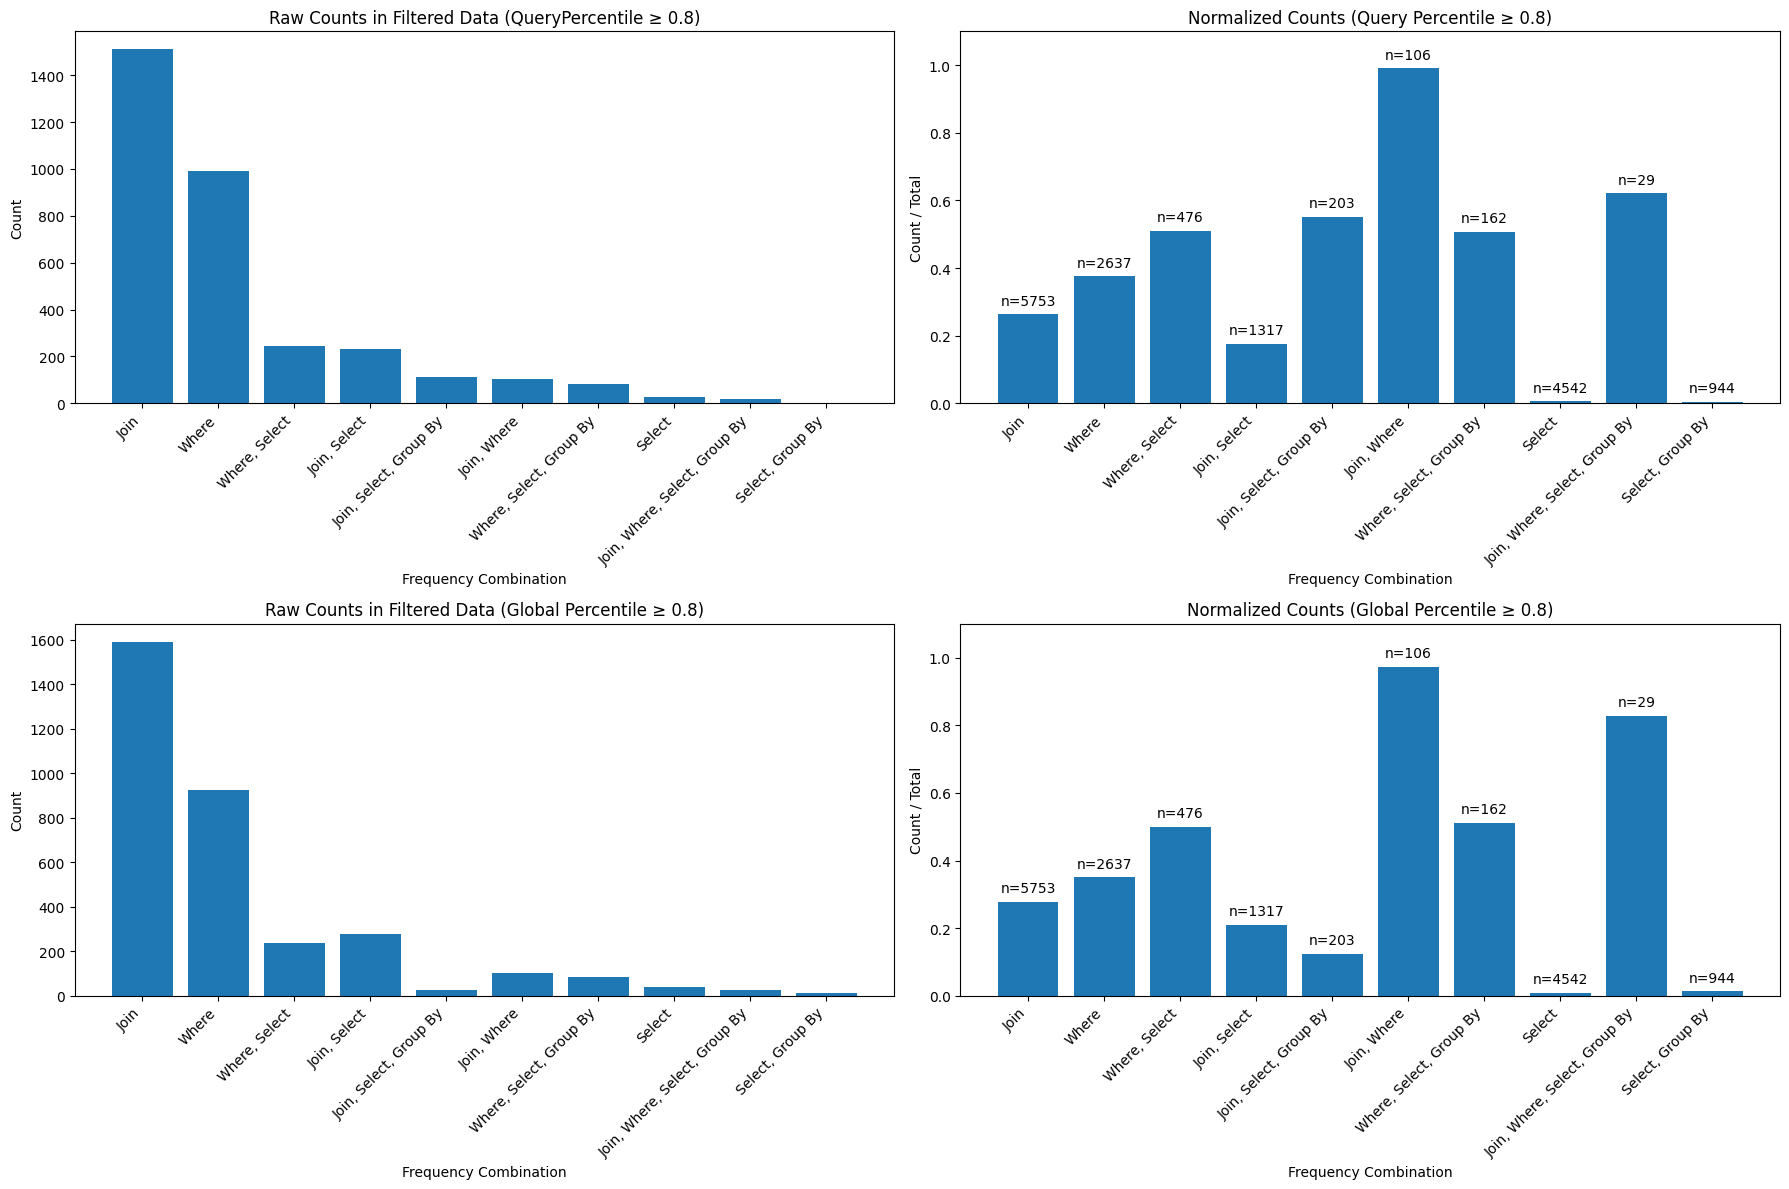

In [1792]:


# Define grouping columns
group_cols = [f"{col} Frequency" for col in frequency_cols]

# Process query percentile data
filtered_grouped_query = group_and_sum(
    filtered_binary_df_query,
    group_cols=group_cols,
    sum_col="Improvement",
    sum_name="FilteredSum",
    count_name="FilteredCount"
)

total_grouped_query = group_and_sum(
    total_binary_df,
    group_cols=group_cols,
    sum_col="Improvement", 
    sum_name="TotalSum",
    count_name="Count"
)

binary_counts_df_query = pd.merge(
    filtered_grouped_query,
    total_grouped_query,
    on=group_cols,
    how="inner"
)

binary_counts_df_query["Label"] = binary_counts_df_query.apply(get_label, axis=1)
binary_counts_df_query["Normalized"] = binary_counts_df_query["FilteredCount"] / binary_counts_df_query["Count"]
binary_counts_df_query = binary_counts_df_query.sort_values('FilteredCount', ascending=False)

# Process global percentile data
filtered_grouped_global = group_and_sum(
    filtered_binary_df_global,
    group_cols=group_cols,
    sum_col="Improvement",
    sum_name="FilteredSum", 
    count_name="FilteredCount"
)

total_grouped_global = group_and_sum(
    total_binary_df,
    group_cols=group_cols,
    sum_col="Improvement",
    sum_name="TotalSum",
    count_name="Count"
)

binary_counts_df_global = pd.merge(
    filtered_grouped_global,
    total_grouped_global,
    on=group_cols,
    how="inner"
)

binary_counts_df_global["Label"] = binary_counts_df_global.apply(get_label, axis=1)
binary_counts_df_global["Normalized"] = binary_counts_df_global["FilteredCount"] / binary_counts_df_global["Count"]
# Sort global percentile data in same order as query percentile data
binary_counts_df_global["sort_order"] = binary_counts_df_global["Label"].map(
    {label: i for i, label in enumerate(binary_counts_df_query["Label"])}
)
binary_counts_df_global = binary_counts_df_global.sort_values('sort_order')

# --- 6. Create plots ---
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))

# Helper to annotate total counts above normalized bars
def _annotate_total_counts(ax, totals):
    for i, p in enumerate(ax.patches):
        total = int(totals.iloc[i])
        ax.text(
            p.get_x() + p.get_width() / 2.,
            p.get_height() + 0.02,
            f'n={total}', ha='center', va='bottom'
        )

# Query percentile plots (binary frequencies)
axes[0,0].bar(binary_counts_df_query['Label'], binary_counts_df_query['FilteredCount'])
axes[0,0].set_xticklabels(binary_counts_df_query['Label'], rotation=45, ha='right')
axes[0,0].set_xlabel('Frequency Combination')
axes[0,0].set_ylabel('Count')
axes[0,0].set_title(f'Raw Counts in Filtered Data (QueryPercentile ≥ {percentile})')

axes[0,1].bar(binary_counts_df_query['Label'], binary_counts_df_query['Normalized'])
axes[0,1].set_xticklabels(binary_counts_df_query['Label'], rotation=45, ha='right')
axes[0,1].set_xlabel('Frequency Combination')
axes[0,1].set_ylabel('Count / Total')
axes[0,1].set_title(f'Normalized Counts (Query Percentile ≥ {percentile})')
axes[0,1].set_ylim(0, 1.1)  # space for annotations
# Annotate using total counts from binary_counts_df_query
_annotate_total_counts(axes[0,1], binary_counts_df_query['Count'])

# Global percentile plots (binary frequencies)
axes[1,0].bar(binary_counts_df_global['Label'], binary_counts_df_global['FilteredCount'])
axes[1,0].set_xticklabels(binary_counts_df_global['Label'], rotation=45, ha='right')
axes[1,0].set_xlabel('Frequency Combination')
axes[1,0].set_ylabel('Count')
axes[1,0].set_title(f'Raw Counts in Filtered Data (Global Percentile ≥ {percentile})')

axes[1,1].bar(binary_counts_df_global['Label'], binary_counts_df_global['Normalized'])
axes[1,1].set_xticklabels(binary_counts_df_global['Label'], rotation=45, ha='right')
axes[1,1].set_xlabel('Frequency Combination')
axes[1,1].set_ylabel('Count / Total')
axes[1,1].set_title(f'Normalized Counts (Global Percentile ≥ {percentile})')
axes[1,1].set_ylim(0, 1.1)
# Annotate using total counts from binary_counts_df_global
_annotate_total_counts(axes[1,1], binary_counts_df_global['Count'])

plt.tight_layout()
plt.show()


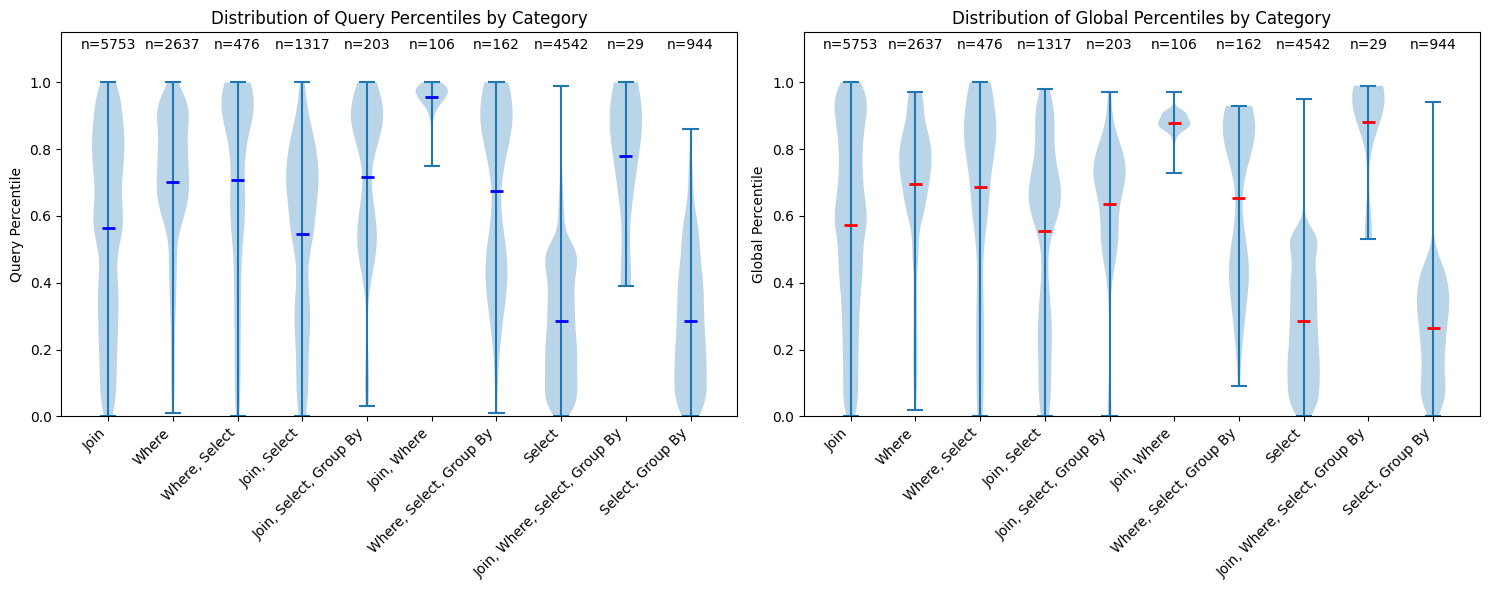

In [1793]:
# Create violin plots for Query and Global percentiles
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Get ordered labels from binary_counts_df_query
ordered_labels = binary_counts_df_query['Label'].tolist()

# Query Percentile violin plot
violin_data_query = [total_binary_df[total_binary_df['Label'] == label]['Query Percentile'] 
                    for label in ordered_labels]
violin_parts_query = ax1.violinplot(violin_data_query, positions=range(len(ordered_labels)))
ax1.set_xticks(range(len(ordered_labels)))
ax1.set_xticklabels(ordered_labels, rotation=45, ha='right')
ax1.set_ylabel('Query Percentile')
ax1.set_title('Distribution of Query Percentiles by Category')
ax1.set_ylim(0, 1.15) # Increase y-limit to make room for annotations

# Add n={number of points} above each violin
for i, data in enumerate(violin_data_query):
    ax1.text(i, 1.1, f'n={len(data)}', ha='center')
    # Add mean line
    mean = data.mean()
    ax1.hlines(mean, i-0.1, i+0.1, color="blue", lw=2)

# Global Percentile violin plot  
violin_data_global = [total_binary_df[total_binary_df['Label'] == label]['Global Percentile']
                     for label in ordered_labels]
violin_parts_global = ax2.violinplot(violin_data_global, positions=range(len(ordered_labels)))
ax2.set_xticks(range(len(ordered_labels)))
ax2.set_xticklabels(ordered_labels, rotation=45, ha='right')
ax2.set_ylabel('Global Percentile')
ax2.set_title('Distribution of Global Percentiles by Category')
ax2.set_ylim(0, 1.15) # Increase y-limit to make room for annotations

# Add n={number of points} above each violin
for i, data in enumerate(violin_data_global):
    ax2.text(i, 1.1, f'n={len(data)}', ha='center')
    # Add mean line
    mean = data.mean()
    ax2.hlines(mean, i-0.1, i+0.1, color='red', lw=2)

plt.tight_layout()
plt.show()


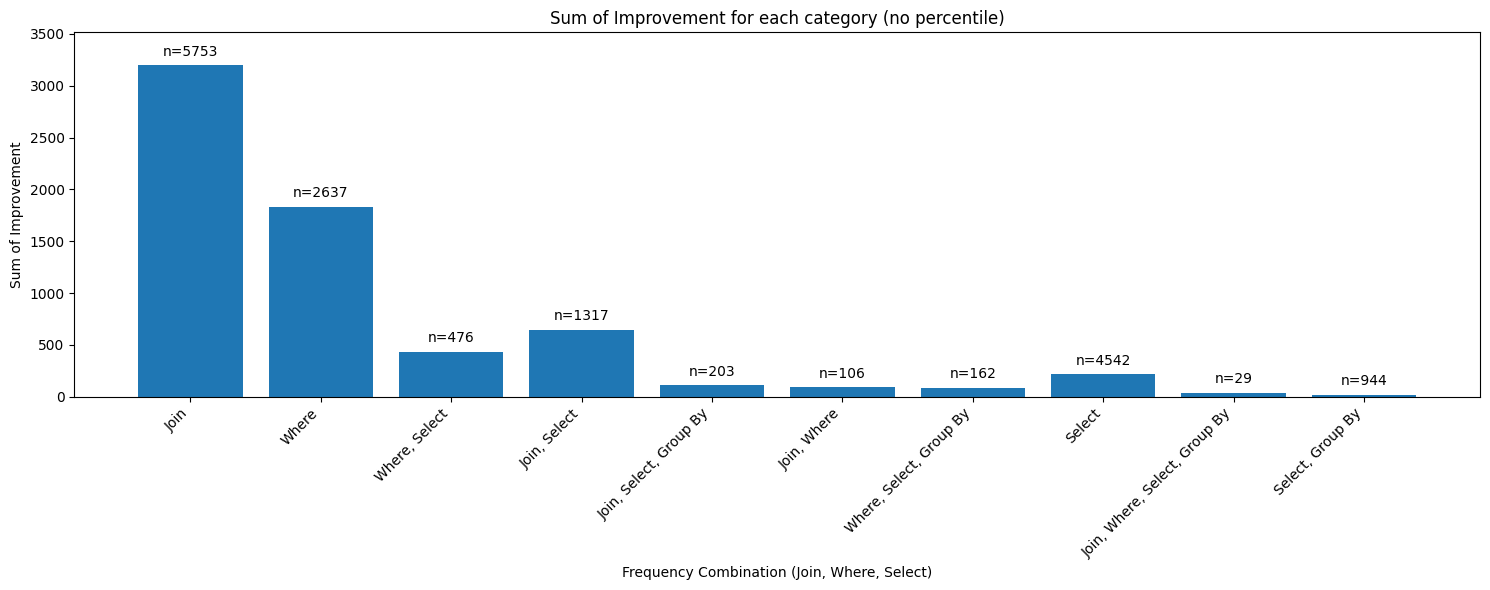

In [1794]:
# --- 7. Sum of Improvement bar plot ---
plt.figure(figsize=(15, 6))
bars = plt.bar(binary_counts_df_global['Label'], binary_counts_df_global['TotalSum'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Frequency Combination (Join, Where, Select)')
plt.ylabel('Sum of Improvement')
plt.title('Sum of Improvement for each category (no percentile)')
# Adjust y-limit for annotation space
ax = plt.gca()
max_height = max(p.get_height() for p in bars)
ax.set_ylim(0, max_height * 1.1)
# Annotate with total counts
for i, p in enumerate(bars):
    total = int(binary_counts_df_global['Count'].iloc[i])
    ax.text(
        p.get_x() + p.get_width() / 2.,
        p.get_height() + max_height * 0.02,
        f'n={total}', ha='center', va='bottom'
    )
plt.tight_layout()
plt.show()

# Only single join

In [1795]:
single_join_df = results_df[(results_df["Total Frequency"] == 1) & (results_df["Join Frequency"] == 1)].copy()


single_join_df["Query Join rank"] = single_join_df.groupby("Query")["Improvement"].rank(ascending=False)
single_join_df["Query Join percentile"] = single_join_df.groupby("Query")["Improvement"].rank(pct=True).round(2)

single_join_df["Global Join rank"] = single_join_df["Improvement"].rank(ascending=False)
single_join_df["Global Join percentile"] = single_join_df["Improvement"].rank(pct=True).round(2)
single_join_df.sort_values(["Query", "Improvement"], ascending=[True, False]).head(20)

Query Materialization  Execution Time  Previous Time  Improvement  \
4203    q10     n_nationkey        1.935326       3.363585     1.428259   
5166    q10     n_nationkey        2.604181       3.410784     0.806604   
10464   q10     n_nationkey        1.921615       2.719775     0.798160   
5301    q10     n_nationkey        2.626658       3.413417     0.786759   
4782    q10     n_nationkey        2.609460       3.394527     0.785067   
9969    q10     n_nationkey        2.605699       3.380399     0.774700   
5409    q10     n_nationkey        2.603144       3.373133     0.769989   
3629    q10     c_nationkey        2.624006       3.392427     0.768421   
11132   q10     n_nationkey        2.596791       3.361020     0.764229   
11120   q10     n_nationkey        2.607393       3.367493     0.760100   
6099    q10     n_nationkey        2.524189       3.283969     0.759780   
3674    q10     c_nationkey        2.608167       3.365207     0.757040   
3626    q10     c_nationkey        2.650439       3.405631     0.755193   
3749    q10     c_nationkey        1.939709       2.688410     0.748701   
5001    q10     n_nationkey        2.643530       3.390593     0.747063   
3641    q10     c_nationkey        2.007859       2.754725     0.746865   
1503    q10     n_nationkey        2.627425       3.371038     0.743613   
3677    q10     c_nationkey        1.994706       2.733709     0.739002   
3725    q10     c_nationkey        2.652299       3.390644     0.738344   
3312    q10     n_nationkey        1.905700       2.641582     0.735882   

          Previous Materializations  Table size  Relative Improvement  \
4203      ['c_nationkey', 'n_name']          25              0.424624   
5166        ['c_address', 'n_name']          25              0.236486   
10464    ['l_returnflag', 'n_name']          25              0.293465   
5301        ['c_comment', 'n_name']          25              0.230490   
4782           ['c_name', 'n_name']          25              0.231274   
9969       ['l_discount', 'n_name']          25              0.229174   
5409        ['c_acctbal', 'n_name']          25              0.228271   
3629        ['c_name', 'c_acctbal']       75000              0.226511   
11132      ['n_name', 'o_orderkey']          25              0.227380   
11120       ['n_name', 'o_custkey']          25              0.225717   
6099       ['l_orderkey', 'n_name']          25              0.231360   
3674      ['c_phone', 'l_discount']       75000              0.224961   
3626        ['c_name', 'c_comment']       75000              0.221748   
3749   ['c_comment', 'o_orderdate']       75000              0.278492   
5001          ['c_phone', 'n_name']          25              0.220334   
3641     ['c_name', 'l_returnflag']       75000              0.271122   
1503                     ['n_name']          25              0.220589   
3677    ['c_phone', 'l_returnflag']       75000              0.270330   
3725    ['c_address', 'o_orderkey']       75000              0.217759   
3312        ['c_custkey', 'n_name']          25              0.278576   

       Query Rank  Query Percentile  ...  Join Frequency  Where Frequency  \
4203            1              1.00  ...               1                0   
5166            5              1.00  ...               1                0   
10464           9              1.00  ...               1                0   
5301           14              0.99  ...               1                0   
4782           16              0.99  ...               1                0   
9969           34              0.98  ...               1                0   
5409           41              0.98  ...               1                0   
3629           45              0.98  ...               1                0   
11132          55              0.97  ...               1                0   
11120          64              0.97  ...               1                0   
6099           65              0.97  ...         

In [1796]:
from enum import IntEnum



class JoinCategory(IntEnum):
    NO_COUNTERPART = 0
    SMALLER_TB__MATERIALIZED_CP = 1 
    SMALLER_TB__UNMATERIALIZED_CP = 2
    LARGER_TB__MATERIALIZED_CP = 3
    LARGER_TB__UNMATERIALIZED_CP = 4


def get_join_category(query_name, materialized_column, previous_materializations, table_size):
    q = queries[query_name]
    counterpart = q.columns_used_in_join()[materialized_column][0]

    if counterpart is None:
        return JoinCategory.NO_COUNTERPART
    
    is_counterpart_materialized = counterpart in previous_materializations
    
    table_size_materialized = table_size
    table_size_counterpart = get_table_size(counterpart)
    
    if table_size_materialized > table_size_counterpart:
        return JoinCategory.LARGER_TB__MATERIALIZED_CP if is_counterpart_materialized else JoinCategory.LARGER_TB__UNMATERIALIZED_CP
    elif table_size_materialized < table_size_counterpart:
        return JoinCategory.SMALLER_TB__MATERIALIZED_CP if is_counterpart_materialized else JoinCategory.SMALLER_TB__UNMATERIALIZED_CP

single_join_df["Join Category"] = single_join_df.apply(lambda row: get_join_category(row["Query"], row["Materialization"], row["Previous Materializations"], row["Table size"]),     axis=1
)

In [1797]:
def get_join_counterpart_table_name(query_name, materialized_column):
    q = queries[query_name]
    counterpart = q.columns_used_in_join()[materialized_column][0]
    if counterpart is None:
        return None
    return get_table_name(counterpart)

def get_join_counterpart_table_size(query_name, materialized_column):
    q = queries[query_name]
    counterpart = q.columns_used_in_join()[materialized_column][0]
    if counterpart is None:
        return None
    return get_table_size(counterpart)

def get_join_counterpart_is_materialized(query_name, materialized_column, previous_materializations):
    q = queries[query_name]
    counterpart = q.columns_used_in_join()[materialized_column][0]
    if counterpart is None:
        return False
    return counterpart in previous_materializations

single_join_df["Join Counterpart Table Name"] = single_join_df.apply(lambda row: get_join_counterpart_table_name(row["Query"], row["Materialization"]), axis=1)
single_join_df["Join Counterpart Table Size"] = single_join_df.apply(lambda row: get_join_counterpart_table_size(row["Query"], row["Materialization"]), axis=1)
single_join_df["Join Counterpart is materialized"] = single_join_df.apply(lambda row: get_join_counterpart_is_materialized(row["Query"], row["Materialization"], row["Previous Materializations"]), axis=1)


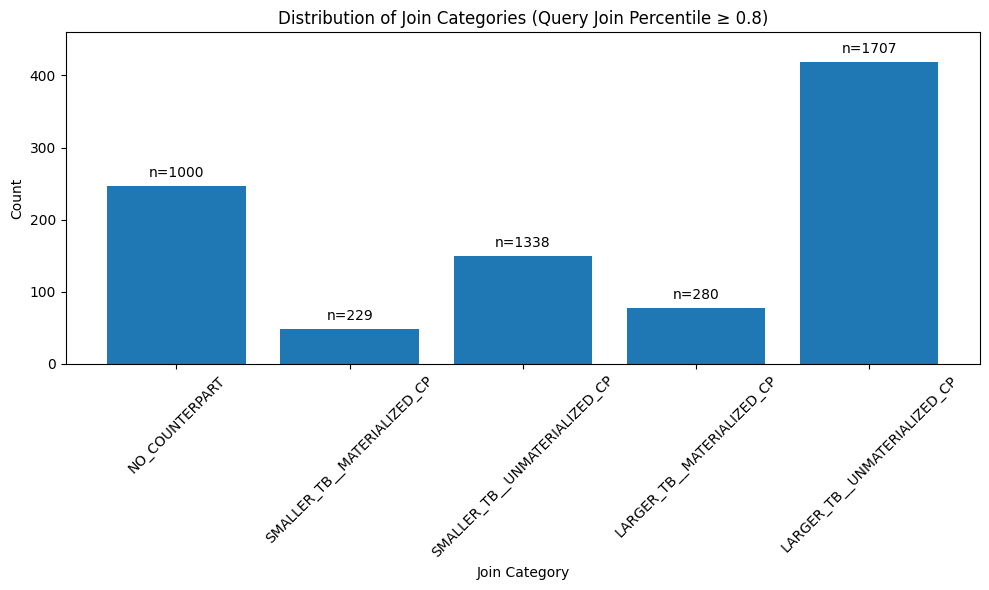

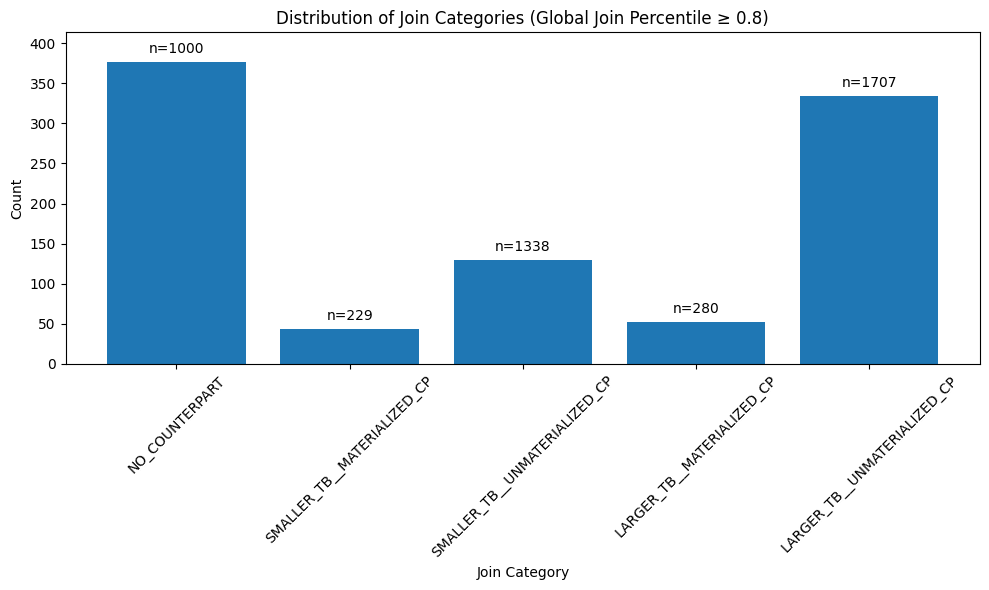

In [1798]:
# --- 8. Join Category Distributions ---
percentile = 0.8
# Prepare data
qj_df = single_join_df[single_join_df['Query Join percentile'] >= percentile]
qj_counts = qj_df.groupby('Join Category').size().reset_index(name='FilteredCount')
qj_counts['Sum'] = qj_df.groupby('Join Category')['Improvement'].sum().values

gj_df = single_join_df[single_join_df['Global Join percentile'] >= percentile]
gj_counts = gj_df.groupby('Join Category').size().reset_index(name='FilteredCount')
gj_counts['Sum'] = gj_df.groupby('Join Category')['Improvement'].sum().values

# Get unfiltered total counts by join category
total_category_counts = single_join_df.groupby('Join Category').size().reset_index(name='TotalCount')

# Plot Query Join Category distribution
plt.figure(figsize=(10, 6))
bars_q = plt.bar(qj_counts['Join Category'], qj_counts['FilteredCount'])
plt.xlabel('Join Category')
plt.ylabel('Count')
plt.title(f'Distribution of Join Categories (Query Join Percentile ≥ {percentile})')
plt.xticks(qj_counts['Join Category'], [cat.name for cat in JoinCategory], rotation=45)
# Annotate with unfiltered total counts
ax = plt.gca()
max_q = max(b.get_height() for b in bars_q)
ax.set_ylim(0, max_q * 1.1)
total_map = dict(zip(total_category_counts['Join Category'], total_category_counts['TotalCount']))
for i, b in enumerate(bars_q):
    total = total_map[b.get_x() and qj_counts['Join Category'].iloc[i]]
    ax.text(b.get_x() + b.get_width() / 2., b.get_height() + max_q * 0.02,
            f'n={total}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

# Plot Global Join Category distribution
plt.figure(figsize=(10, 6))
bars_g = plt.bar(gj_counts['Join Category'], gj_counts['FilteredCount'])
plt.xlabel('Join Category')
plt.ylabel('Count')
plt.title(f'Distribution of Join Categories (Global Join Percentile ≥ {percentile})')
plt.xticks(gj_counts['Join Category'], [cat.name for cat in JoinCategory], rotation=45)
# Annotate with unfiltered total counts
ax = plt.gca()
max_g = max(b.get_height() for b in bars_g)
ax.set_ylim(0, max_g * 1.1)
for i, b in enumerate(bars_g):
    total = total_map[gj_counts['Join Category'].iloc[i]]
    ax.text(b.get_x() + b.get_width() / 2., b.get_height() + max_g * 0.02,
            f'n={total}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

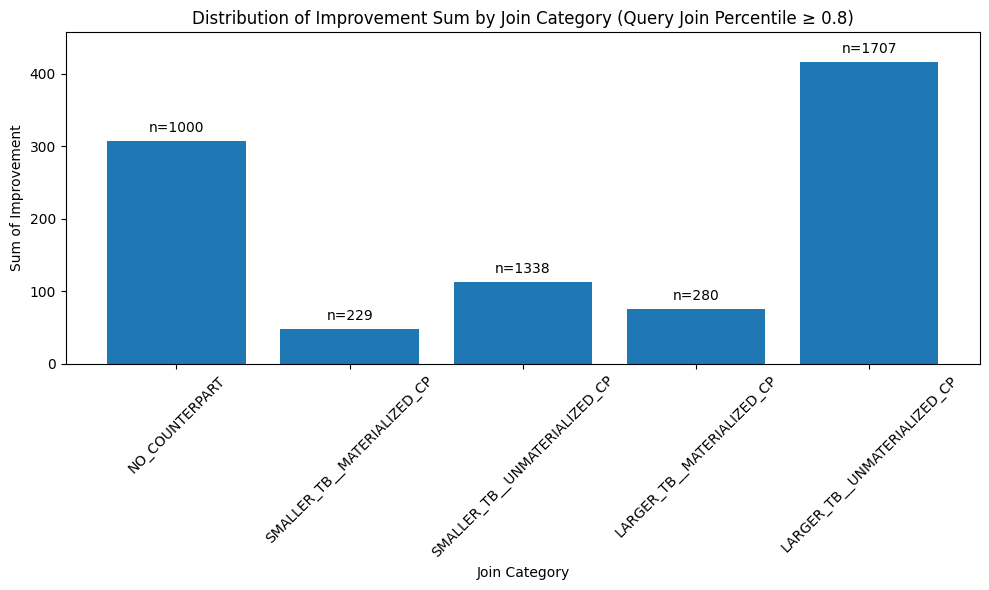

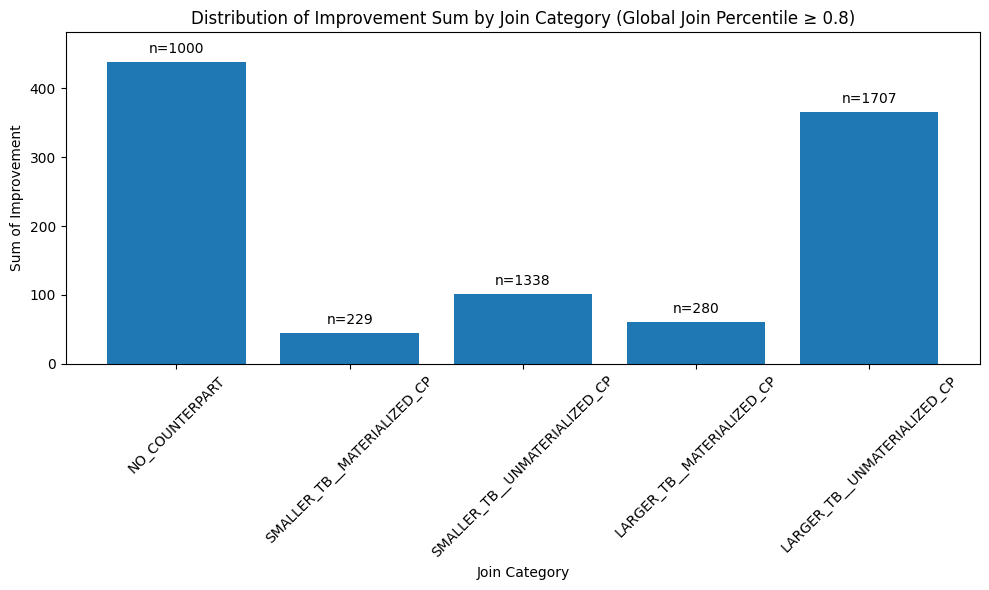

In [1799]:
# Make the plot: Sum of Improvement by Join Category (Query)
plt.figure(figsize=(10,6))
bars_q_sum = plt.bar(qj_counts['Join Category'], qj_counts['Sum'])
plt.xlabel('Join Category')
plt.ylabel('Sum of Improvement')
plt.title(f'Distribution of Improvement Sum by Join Category (Query Join Percentile ≥ {percentile})')
plt.xticks(qj_counts['Join Category'], [cat.name for cat in JoinCategory], rotation=45)
# Annotate with unfiltered total counts
ax = plt.gca()
max_q_sum = max(b.get_height() for b in bars_q_sum)
ax.set_ylim(0, max_q_sum * 1.1)
for i, b in enumerate(bars_q_sum):
    total = total_map[qj_counts['Join Category'].iloc[i]]
    ax.text(b.get_x() + b.get_width() / 2., b.get_height() + max_q_sum * 0.02,
            f'n={total}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

# Make the plot: Sum of Improvement by Join Category (Global)
plt.figure(figsize=(10,6))
bars_g_sum = plt.bar(gj_counts['Join Category'], gj_counts['Sum'])
plt.xlabel('Join Category')
plt.ylabel('Sum of Improvement')
plt.title(f'Distribution of Improvement Sum by Join Category (Global Join Percentile ≥ {percentile})')
plt.xticks(gj_counts['Join Category'], [cat.name for cat in JoinCategory], rotation=45)
# Annotate with unfiltered total counts
ax = plt.gca()
max_g_sum = max(b.get_height() for b in bars_g_sum)
ax.set_ylim(0, max_g_sum * 1.1)
for i, b in enumerate(bars_g_sum):
    total = total_map[gj_counts['Join Category'].iloc[i]]
    ax.text(b.get_x() + b.get_width() / 2., b.get_height() + max_g_sum * 0.02,
            f'n={total}', ha='center', va='bottom')
plt.tight_layout()
plt.show()


/var/folders/6s/wqp33w8x1s79241ysd40kr500000gn/T/ipykernel_29052/3336271675.py:15: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  total = int(total_category_counts.loc[total_category_counts['Join Category'] == cat.value, 'TotalCount'])


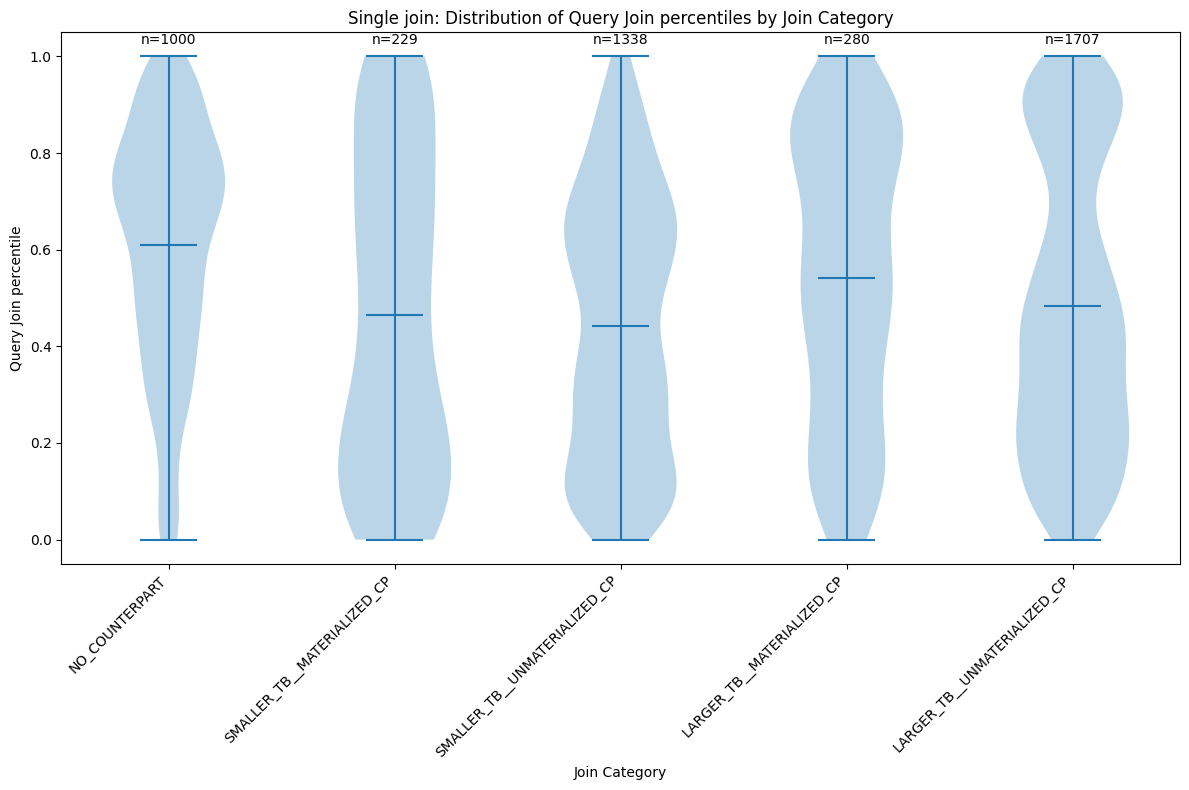

/var/folders/6s/wqp33w8x1s79241ysd40kr500000gn/T/ipykernel_29052/3336271675.py:31: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  total = int(total_category_counts.loc[total_category_counts['Join Category'] == cat.value, 'TotalCount'])


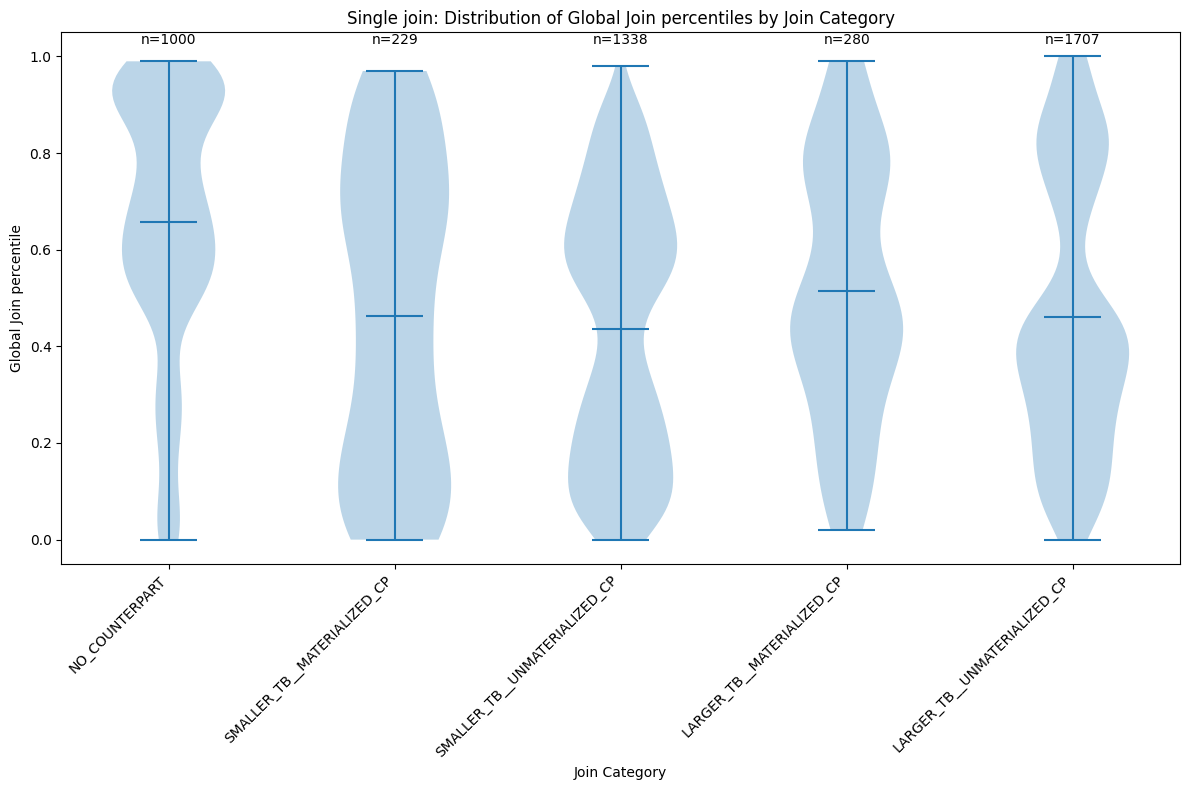

In [1800]:
# --- 9. Violin plots for percentiles by Join Category with total counts ---
# Calculate total counts per category
total_category_counts = single_join_df.groupby('Join Category').size().reset_index(name='TotalCount')
# Query Join percentile violins
plt.figure(figsize=(12, 8))
percentiles_q = [single_join_df[single_join_df['Join Category'] == cat.value]['Query Join percentile'] for cat in JoinCategory]
vp_q = plt.violinplot(percentiles_q, showmeans=True)
plt.xticks(range(1, len(JoinCategory) + 1), [cat.name for cat in JoinCategory], rotation=45, ha='right')
plt.xlabel('Join Category')
plt.ylabel('Query Join percentile')
plt.title('Single join: Distribution of Query Join percentiles by Join Category')
ax = plt.gca()
max_qp = max([max(v) if len(v)>0 else 0 for v in percentiles_q])
for i, cat in enumerate(JoinCategory):
    total = int(total_category_counts.loc[total_category_counts['Join Category'] == cat.value, 'TotalCount'])
    ax.text(i+1, 1.02, f'n={total}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

# Global Join percentile violins
plt.figure(figsize=(12, 8))
percentiles_g = [single_join_df[single_join_df['Join Category'] == cat.value]['Global Join percentile'] for cat in JoinCategory]
vp_g = plt.violinplot(percentiles_g, showmeans=True)
plt.xticks(range(1, len(JoinCategory) + 1), [cat.name for cat in JoinCategory], rotation=45, ha='right')
plt.xlabel('Join Category')
plt.ylabel('Global Join percentile')
plt.title('Single join: Distribution of Global Join percentiles by Join Category')
ax = plt.gca()
max_gp = max([max(v) if len(v)>0 else 0 for v in percentiles_g])
for i, cat in enumerate(JoinCategory):
    total = int(total_category_counts.loc[total_category_counts['Join Category'] == cat.value, 'TotalCount'])
    ax.text(i+1, 1.02, f'n={total}', ha='center', va='bottom')
plt.tight_layout()
plt.show()


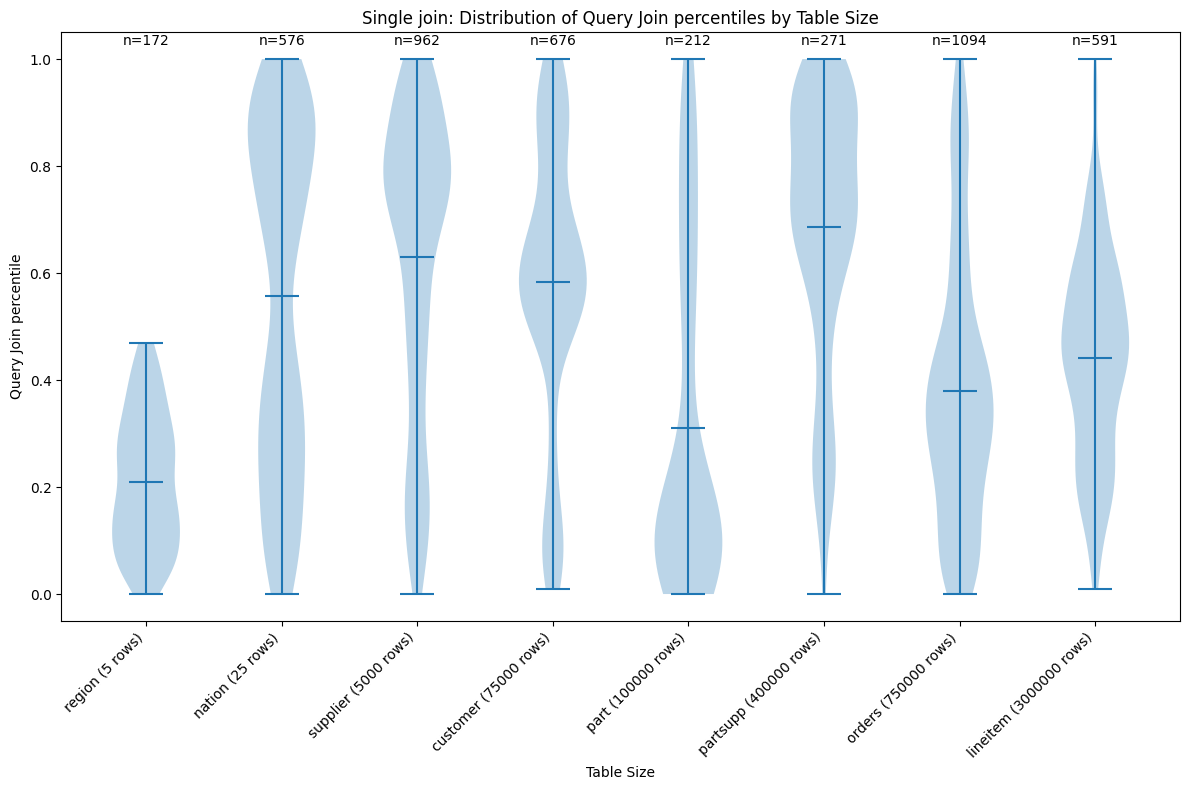

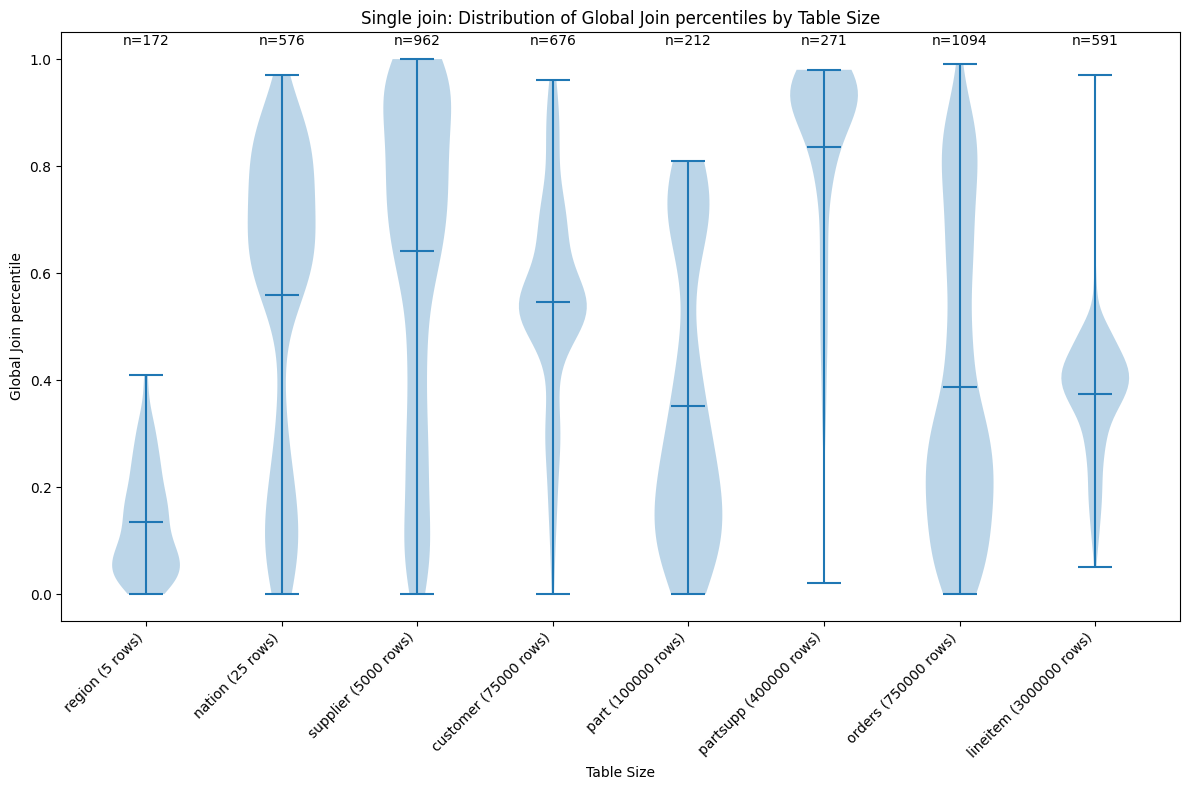

In [1801]:
# Sort the dataframe by improvement
single_join_df.sort_values("Improvement", ascending=False, inplace=True)

# Create categories by table size for Query Join percentile
table_size_query_percentiles = {
    'region (5 rows)': single_join_df[single_join_df['Table size'] == 5]['Query Join percentile'],
    'nation (25 rows)': single_join_df[single_join_df['Table size'] == 25]['Query Join percentile'], 
    'supplier (5000 rows)': single_join_df[single_join_df['Table size'] == 5000]['Query Join percentile'],
    'customer (75000 rows)': single_join_df[single_join_df['Table size'] == 75000]['Query Join percentile'],
    'part (100000 rows)': single_join_df[single_join_df['Table size'] == 100000]['Query Join percentile'],
    'partsupp (400000 rows)': single_join_df[single_join_df['Table size'] == 400000]['Query Join percentile'],
    'orders (750000 rows)': single_join_df[single_join_df['Table size'] == 750000]['Query Join percentile'],
    'lineitem (3000000 rows)': single_join_df[single_join_df['Table size'] == 3000000]['Query Join percentile']
}

# Create categories by table size for Global Join percentile
table_size_global_percentiles = {
    'region (5 rows)': single_join_df[single_join_df['Table size'] == 5]['Global Join percentile'],
    'nation (25 rows)': single_join_df[single_join_df['Table size'] == 25]['Global Join percentile'],
    'supplier (5000 rows)': single_join_df[single_join_df['Table size'] == 5000]['Global Join percentile'],
    'customer (75000 rows)': single_join_df[single_join_df['Table size'] == 75000]['Global Join percentile'],
    'part (100000 rows)': single_join_df[single_join_df['Table size'] == 100000]['Global Join percentile'],
    'partsupp (400000 rows)': single_join_df[single_join_df['Table size'] == 400000]['Global Join percentile'],
    'orders (750000 rows)': single_join_df[single_join_df['Table size'] == 750000]['Global Join percentile'],
    'lineitem (3000000 rows)': single_join_df[single_join_df['Table size'] == 3000000]['Global Join percentile']
}

# Create first plot for Query Join percentile
plt.figure(figsize=(12, 8))

violin_plot1 = plt.violinplot(
    list(table_size_query_percentiles.values()),
    showmeans=True
)

plt.xticks(
    range(1, len(table_size_query_percentiles) + 1),
    list(table_size_query_percentiles.keys()),
    rotation=45,
    ha='right'
)

plt.xlabel('Table Size')
plt.ylabel('Query Join percentile')
plt.title('Single join: Distribution of Query Join percentiles by Table Size')

# Add n counts above each violin
ax = plt.gca()
max_height = max([max(v) if len(v)>0 else 0 for v in table_size_query_percentiles.values()])
for i, (key, values) in enumerate(table_size_query_percentiles.items(), 1):
    ax.text(i, max_height * 1.02, f'n={len(values)}', ha='center', va='bottom')

plt.tight_layout()

# Create second plot for Global Join percentile
plt.figure(figsize=(12, 8))

violin_plot2 = plt.violinplot(
    list(table_size_global_percentiles.values()),
    showmeans=True
)

plt.xticks(
    range(1, len(table_size_global_percentiles) + 1),
    list(table_size_global_percentiles.keys()),
    rotation=45,
    ha='right'
)

plt.xlabel('Table Size')
plt.ylabel('Global Join percentile')
plt.title('Single join: Distribution of Global Join percentiles by Table Size')

# Add n counts above each violin
ax = plt.gca()
max_height = max([max(v) if len(v)>0 else 0 for v in table_size_global_percentiles.values()])
for i, (key, values) in enumerate(table_size_global_percentiles.items(), 1):
    ax.text(i, max_height * 1.02, f'n={len(values)}', ha='center', va='bottom')

plt.tight_layout()


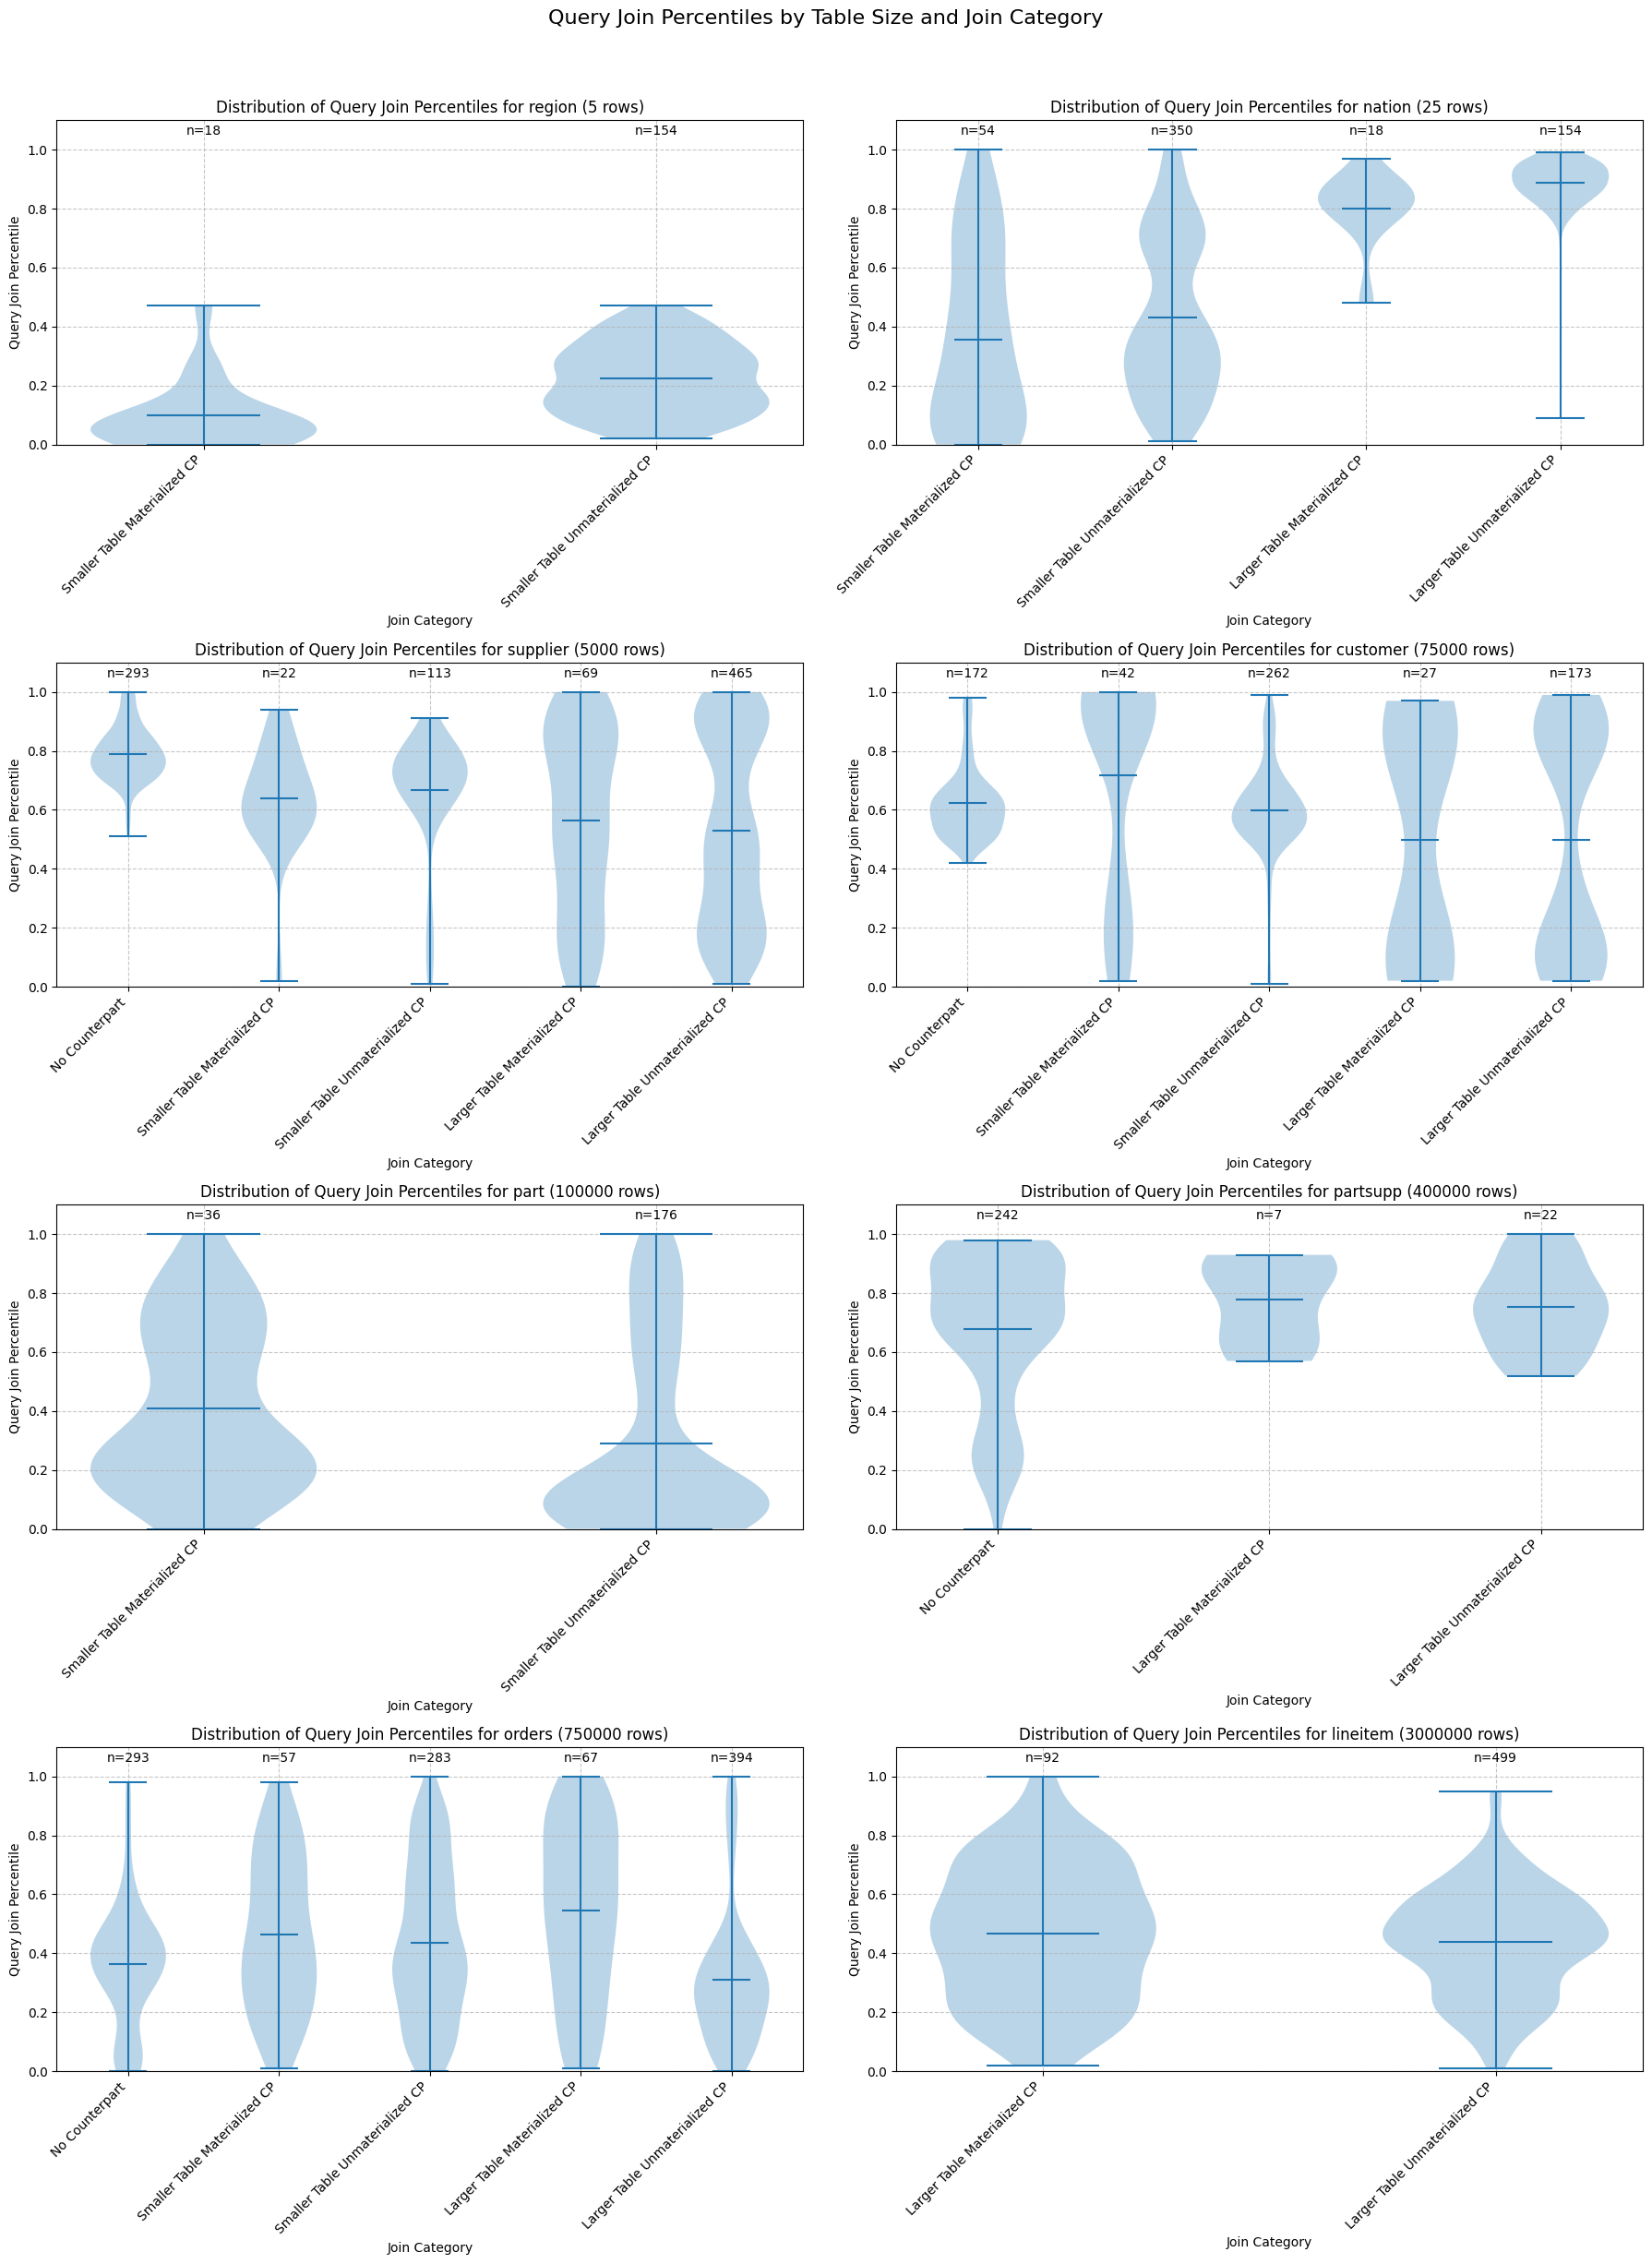

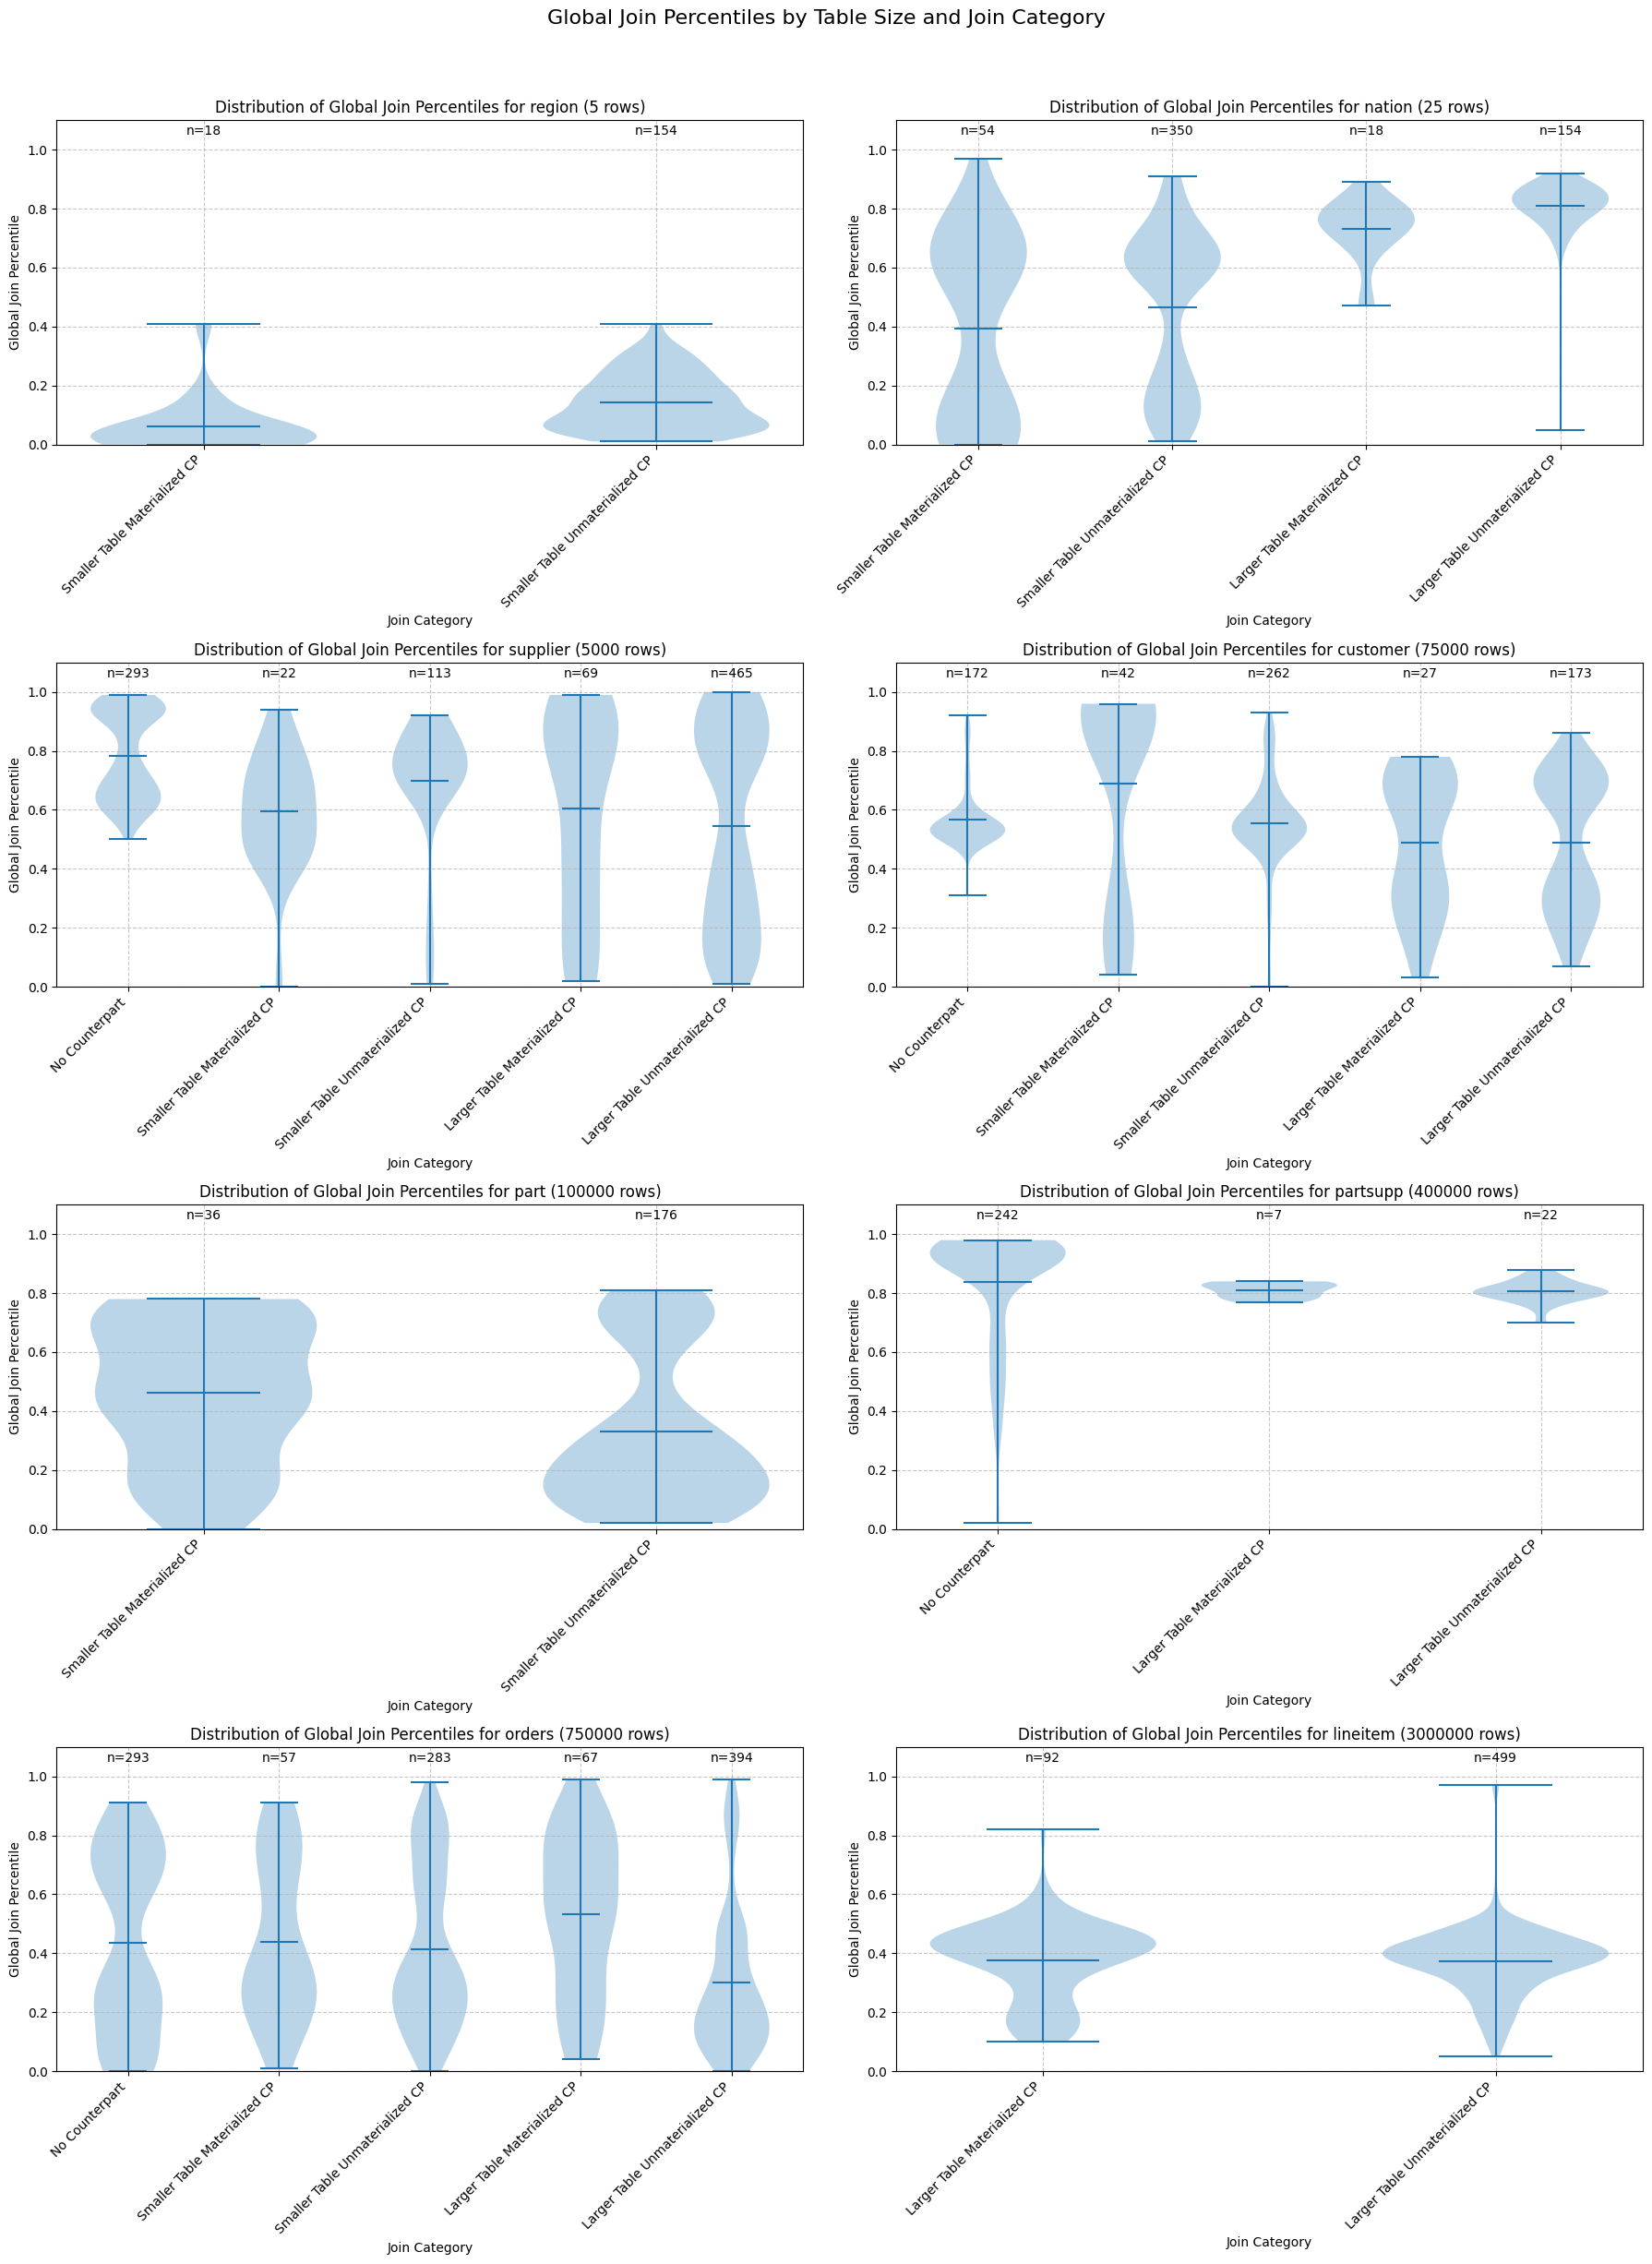

In [1802]:
# Sort the dataframe by improvement
single_join_df.sort_values("Improvement", ascending=False, inplace=True)

# Create figures with subplots
fig1, axes1 = plt.subplots(4, 2, figsize=(18, 24))
fig2, axes2 = plt.subplots(4, 2, figsize=(18, 24))
axes1 = axes1.flatten()
axes2 = axes2.flatten()

# Table sizes and their labels
table_sizes = {
    5: 'region (5 rows)',
    25: 'nation (25 rows)', 
    5000: 'supplier (5000 rows)',
    75000: 'customer (75000 rows)',
    100000: 'part (100000 rows)',
    400000: 'partsupp (400000 rows)',
    750000: 'orders (750000 rows)',
    3000000: 'lineitem (3000000 rows)'
}

# Category labels
category_labels = {
    JoinCategory.NO_COUNTERPART: 'No Counterpart',
    JoinCategory.SMALLER_TB__MATERIALIZED_CP: 'Smaller Table Materialized CP',
    JoinCategory.SMALLER_TB__UNMATERIALIZED_CP: 'Smaller Table Unmaterialized CP', 
    JoinCategory.LARGER_TB__MATERIALIZED_CP: 'Larger Table Materialized CP',
    JoinCategory.LARGER_TB__UNMATERIALIZED_CP: 'Larger Table Unmaterialized CP'
}

# Create violin plots for each table size
for idx, (size, label) in enumerate(table_sizes.items()):
    # For Query Join Percentile
    data1 = []
    # For Global Join Percentile  
    data2 = []
    categories_present = []
    counts = []
    
    for cat in JoinCategory:
        df_subset = single_join_df[(single_join_df['Table size'] == size) & 
                                 (single_join_df['Join Category'] == cat)]
        
        # Only append if there is data
        if len(df_subset) > 0:
            data1.append(df_subset['Query Join percentile'])
            data2.append(df_subset['Global Join percentile'])
            categories_present.append(category_labels[cat])
            counts.append(len(df_subset))
    
    # Only create violin plots if we have data
    if len(data1) > 0:
        # Query Join Percentile plot
        violin_plot1 = axes1[idx].violinplot(data1, showmeans=True)
        axes1[idx].set_xticks(range(1, len(data1) + 1))
        axes1[idx].set_xticklabels(categories_present, rotation=45, ha='right')
        axes1[idx].set_xlabel('Join Category')
        axes1[idx].set_ylabel('Query Join Percentile')
        axes1[idx].set_title(f'Distribution of Query Join Percentiles for {label}')
        axes1[idx].grid(True, linestyle='--', alpha=0.7)
        axes1[idx].set_ylim(0, 1.1) # Increased y-limit to make room for count labels
        
        # Add count labels above each violin, positioned higher
        for i, count in enumerate(counts):
            axes1[idx].text(i+1, 1.05, f'n={count}', ha='center')
        
        # Global Join Percentile plot
        violin_plot2 = axes2[idx].violinplot(data2, showmeans=True)
        axes2[idx].set_xticks(range(1, len(data2) + 1))
        axes2[idx].set_xticklabels(categories_present, rotation=45, ha='right')
        axes2[idx].set_xlabel('Join Category')
        axes2[idx].set_ylabel('Global Join Percentile')
        axes2[idx].set_title(f'Distribution of Global Join Percentiles for {label}')
        axes2[idx].grid(True, linestyle='--', alpha=0.7)
        axes2[idx].set_ylim(0, 1.1) # Increased y-limit to make room for count labels
        
        # Add count labels above each violin, positioned higher
        for i, count in enumerate(counts):
            axes2[idx].text(i+1, 1.05, f'n={count}', ha='center')
            
    else:
        axes1[idx].text(0.5, 0.5, 'No data available', 
                      horizontalalignment='center',
                      verticalalignment='center')
        axes1[idx].set_title(f'Distribution of Query Join Percentiles for {label}')
        axes1[idx].set_ylim(0, 1.1)
        
        axes2[idx].text(0.5, 0.5, 'No data available',
                      horizontalalignment='center', 
                      verticalalignment='center')
        axes2[idx].set_title(f'Distribution of Global Join Percentiles for {label}')
        axes2[idx].set_ylim(0, 1.1)

fig1.suptitle('Query Join Percentiles by Table Size and Join Category', y=1.02, fontsize=16)
fig2.suptitle('Global Join Percentiles by Table Size and Join Category', y=1.02, fontsize=16)
fig1.tight_layout()
fig2.tight_layout()


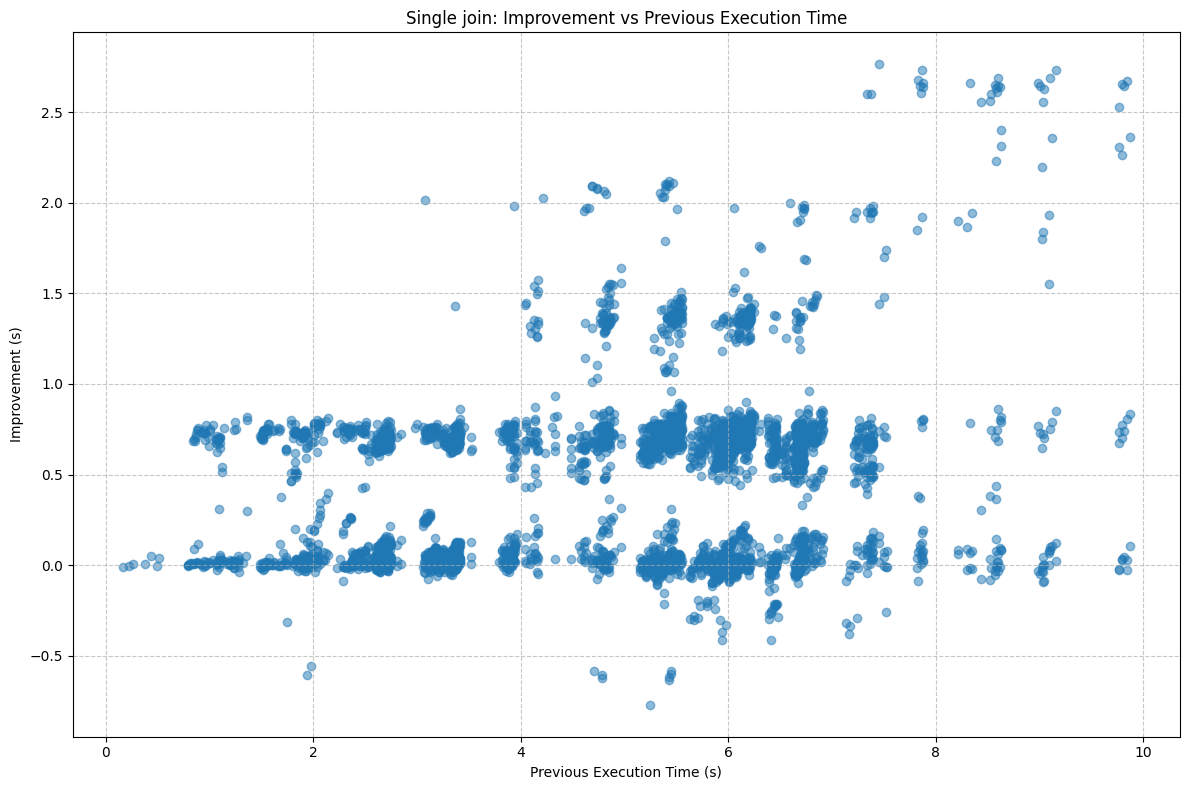

In [1803]:
# Create scatter plot
plt.figure(figsize=(12, 8))
plt.scatter( single_join_df['Previous Time'], single_join_df['Improvement'], alpha=0.5)

# Add labels and title
plt.xlabel('Previous Execution Time (s)')
plt.ylabel('Improvement (s)')
plt.title('Single join: Improvement vs Previous Execution Time')

# Add grid
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

In [1804]:
single_join_df[single_join_df["Join Counterpart Table Name"] == "lineitem"]

Query Materialization  Execution Time  Previous Time  Improvement  \
13623    q7      o_orderkey        4.534677       6.061884     1.527207   
8646     q7       s_suppkey        5.303601       6.649153     1.345552   
10867   q21       s_suppkey        7.741276       8.603535     0.862258   
13806   q21       s_suppkey        8.304135       9.154678     0.850543   
11979   q21       s_suppkey        9.035222       9.867757     0.832536   
...     ...             ...             ...            ...          ...   
8658    q21       s_suppkey        6.310958       5.941099    -0.369859   
9681     q7      o_orderkey        6.032043       5.448199    -0.583844   
7536     q9       p_partkey        5.289778       4.705006    -0.584772   
10638    q7      o_orderkey        5.408344       4.785844    -0.622500   
10293    q7      o_orderkey        6.061104       5.429380    -0.631724   

                Previous Materializations  Table size  Relative Improvement  \
13623        ['o_custkey', 's_nationkey']      750000              0.251936   
8646         ['l_suppkey', 's_nationkey']        5000              0.202364   
10867      ['l_commitdate', 'o_orderkey']        5000              0.100221   
13806         ['o_orderstatus', 's_name']        5000              0.092908   
11979           ['n_nationkey', 's_name']        5000              0.084369   
...                                   ...         ...                   ...   
8658         ['l_suppkey', 's_nationkey']        5000             -0.062254   
9681   ['l_extendedprice', 's_nationkey']      750000             -0.107163   
7536         ['l_partkey', 's_nationkey']      100000             -0.124287   
10638       ['l_shipdate', 's_nationkey']      750000             -0.130071   
10293       ['l_discount', 's_nationkey']      750000             -0.116353   

       Query Rank  Query Percentile  ...  Order By Frequency  \
13623         108              0.90  ...                   0   
8646          137              0.87  ...                   0   
10867         281              0.55  ...                   0   
13806         283              0.54  ...                   0   
11979         288              0.53  ...                   0   
...           ...               ...  ...                 ...   
8658          613              0.01  ...                   0   
9681         1022              0.01  ...                   0   
7536         1933              0.00  ...                   0   
10638        1026              0.00  ...                   0   
10293        1027              0.00  ...                   0   

       Self Join Frequency Query Join rank  Query Join percentile  \
13623                    0            23.0                   0.97   
8646                     0            40.0                   0.94   
10867                    0            57.0                   0.75   
13806                    0            58.0                   0.75   
11979                    0            59.0                   0.74   
...                    ...             ...                    ...   
8658                     0           221.0                   0.02   
9681                     0           627.0                   0.01   
7536                     0           847.0                   0.00   
10638                    0           631.0                   0.00   
10293                    0           632.0                   0.00   

       Global Join rank  Global Join percentile  Join Category  \
13623             104.0                    0.98              2   
8646              260.0                    0.94              1   
10867             367.0                    0.92              2   
13806             374.0                    0.92              2   
11979             390.0                    0.91              2   
...                 ...                     ...            ...   
8658             4541.0                    0.00              1   
9681             4546.0       

In [1805]:
results_df

Query Materialization  Execution Time  Previous Time  Improvement  \
5642    q21      l_orderkey        4.791888       8.210625     3.418738   
5549    q21      l_orderkey        4.241371       7.454519     3.213148   
577     q21      l_orderkey        5.472538       8.574982     3.102444   
5561    q21      l_orderkey        5.485127       8.583792     3.098665   
5576    q21      l_orderkey        4.759518       7.845612     3.086095   
...     ...             ...             ...            ...          ...   
13197   q11     ps_availqty        3.045776       1.596690    -1.449086   
2329    q11   ps_supplycost        4.529327       3.078928    -1.450400   
11901   q11   ps_supplycost        4.570223       3.088974    -1.481249   
2307    q11     ps_availqty        4.570017       3.078928    -1.491090   
11868   q11     ps_availqty        4.581160       3.088974    -1.492186   

            Previous Materializations  Table size  Relative Improvement  \
5642       ['l_suppkey', 's_suppkey']     3000000              0.416380   
5549   ['l_suppkey', 'l_receiptdate']     3000000              0.431034   
577                     ['l_suppkey']     3000000              0.361802   
5561     ['l_suppkey', 'n_nationkey']     3000000              0.360990   
5576          ['l_suppkey', 'n_name']     3000000              0.393353   
...                               ...         ...                   ...   
13197       ['n_name', 's_nationkey']      400000             -0.907557   
2329                  ['s_nationkey']      400000             -0.471073   
11901  ['n_nationkey', 's_nationkey']      400000             -0.479528   
2307                  ['s_nationkey']      400000             -0.484289   
11868  ['n_nationkey', 's_nationkey']      400000             -0.483068   

       Query Rank  Query Percentile  Global Rank  Global Percentile  \
5642            1              1.00            1                1.0   
5549            2              1.00            2                1.0   
577             3              1.00            3                1.0   
5561            4              1.00            4                1.0   
5576            5              0.99            5                1.0   
...           ...               ...          ...                ...   
13197         228              0.02        16165                0.0   
2329          229              0.02        16166                0.0   
11901         230              0.01        16167                0.0   
2307          231              0.01        16168                0.0   
11868         232              0.00        16169                0.0   

      Column Type  Total Frequency  Join Frequency  Where Frequency  \
5642          INT                5               1                0   
5549          INT                5               1                0   
577           INT                5               1                0   
5561          INT                5               1                0   
5576          INT                5               1                0   
...           ...              ...             ...              ...   
13197         INT                3               0                1   
2329          INT                3               0                1   
11901         INT                3               0                1   
2307          INT                3               0                1   
11868         INT                3               0                1   

       Select Frequency  Group By Frequency  Order By Frequency  \
5642                  0                   0                   0   
5549                  0                   0                   0   
577                   0                   0                   0   
5561                  0                   0                   0   
5576                  0                   0                   0   
...                 ...                 ...                 ...   
13197                 2      

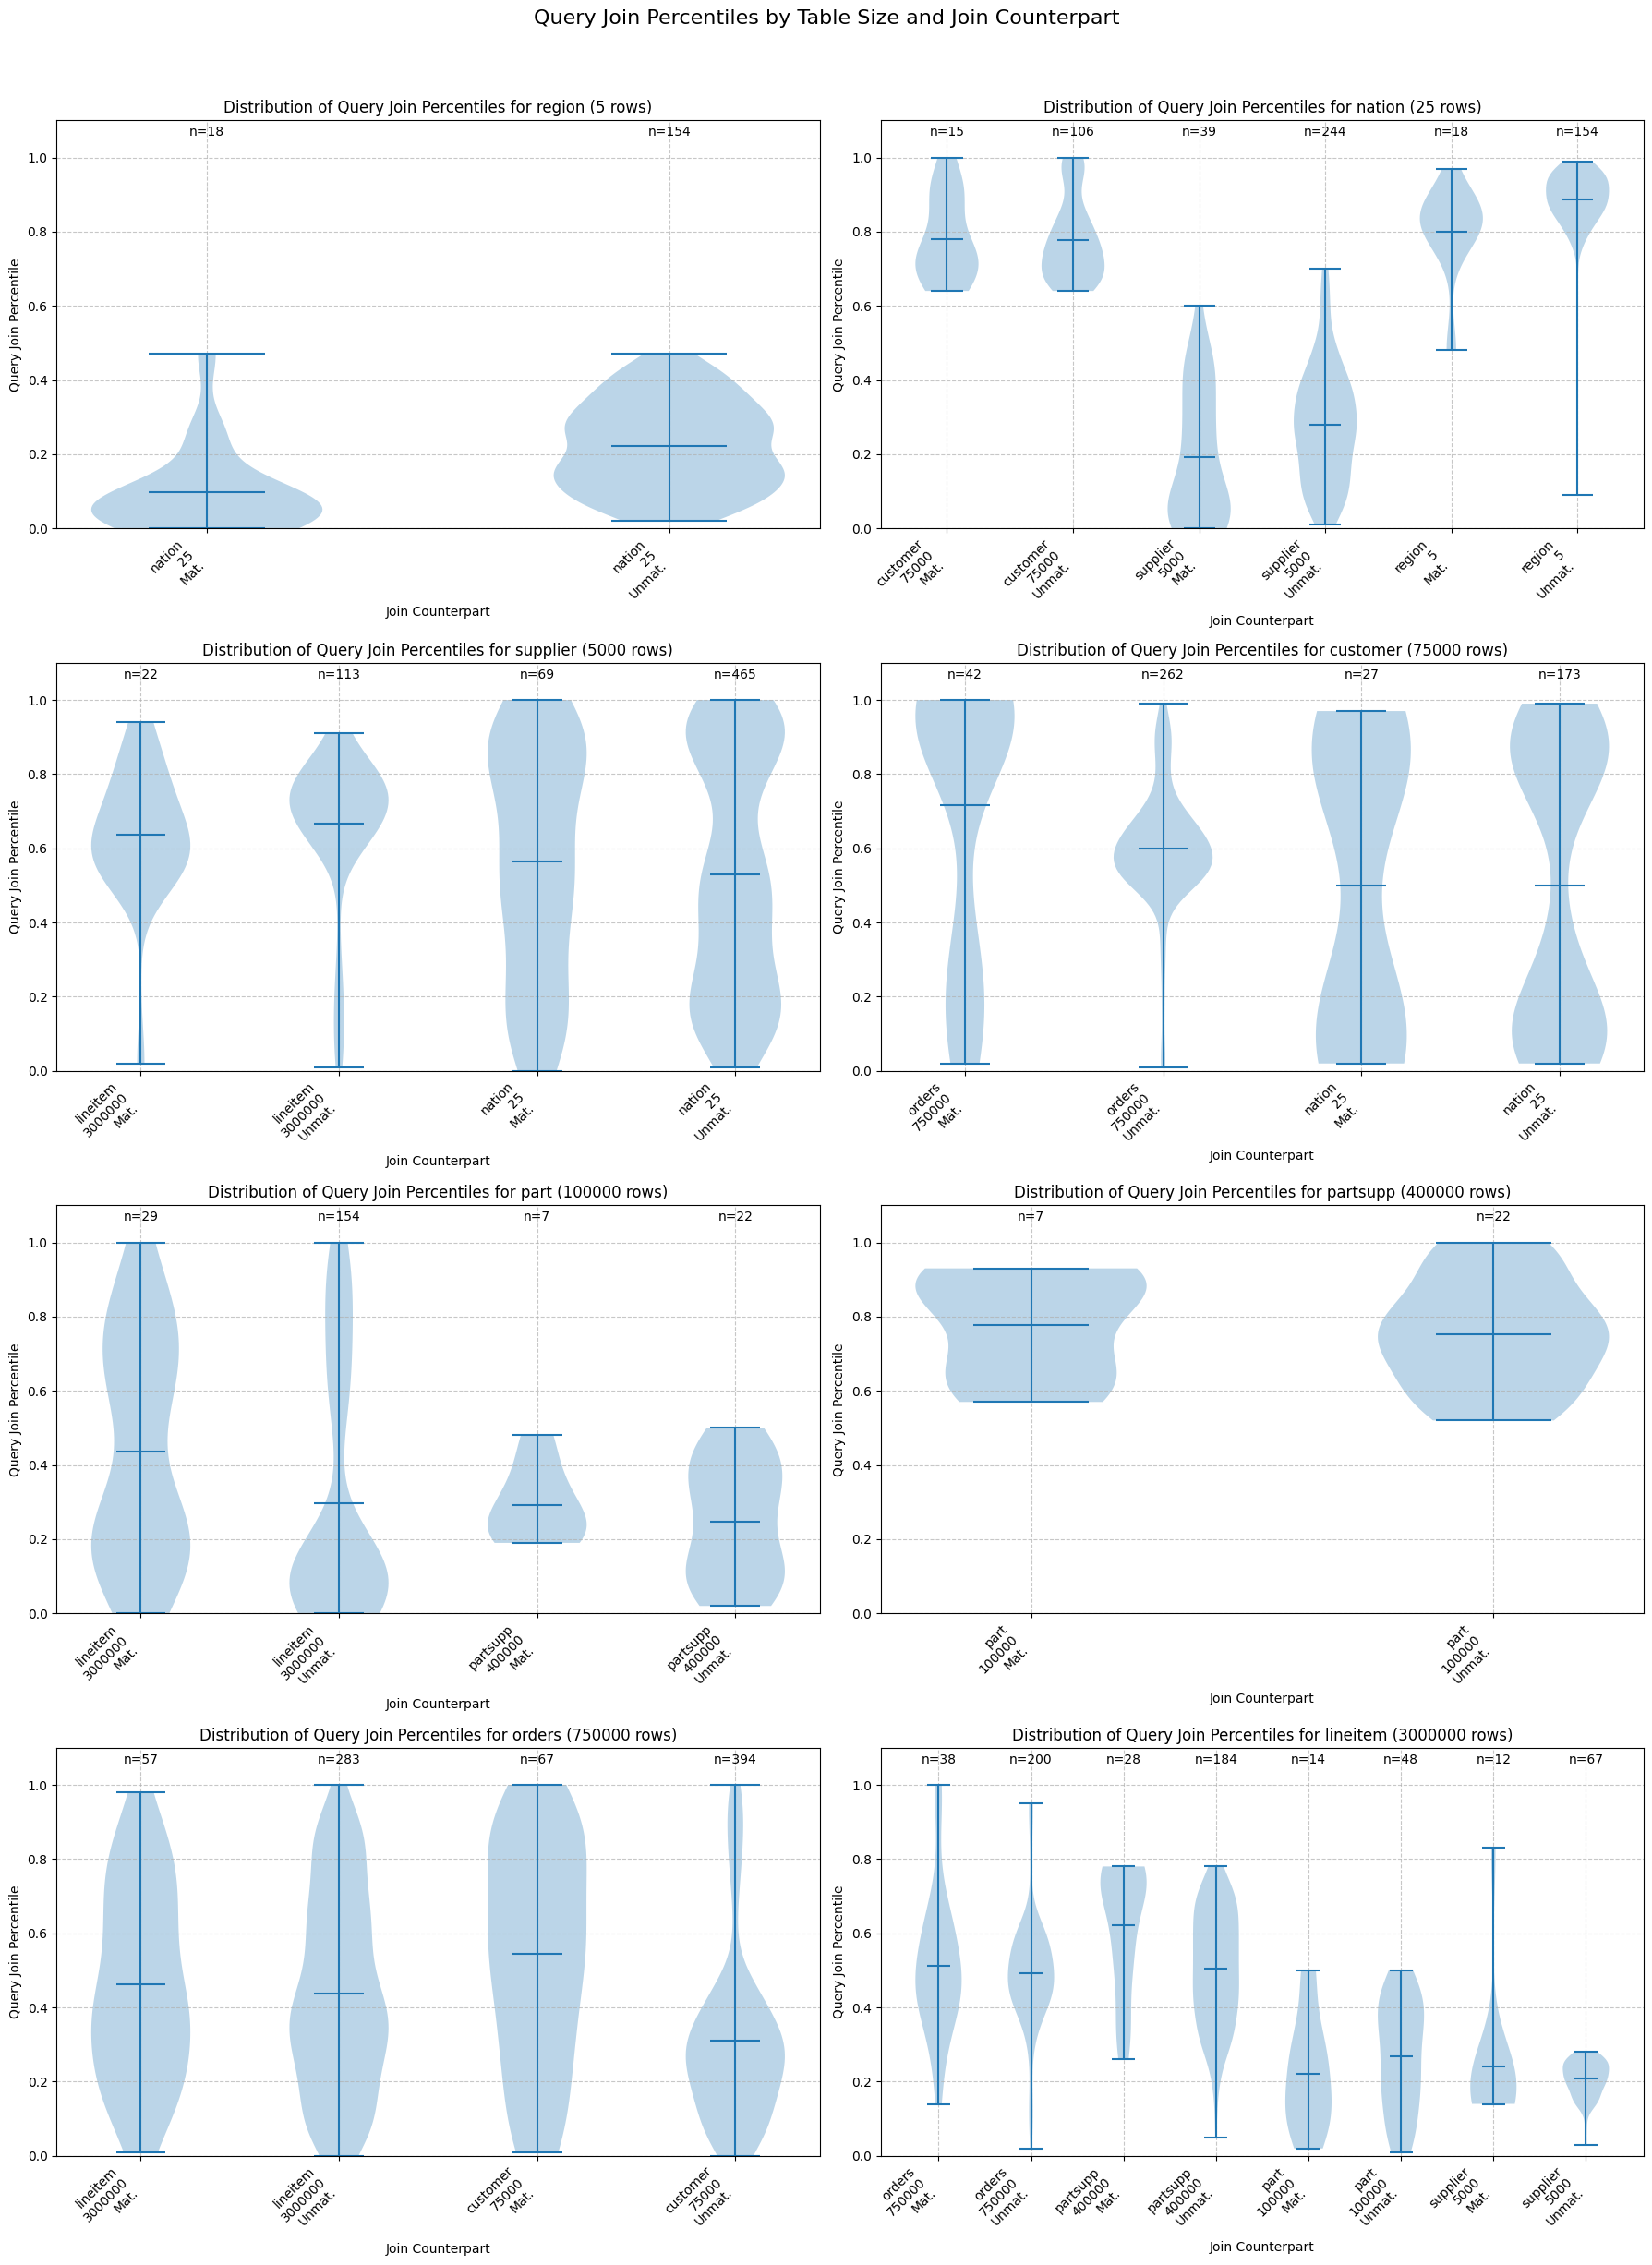

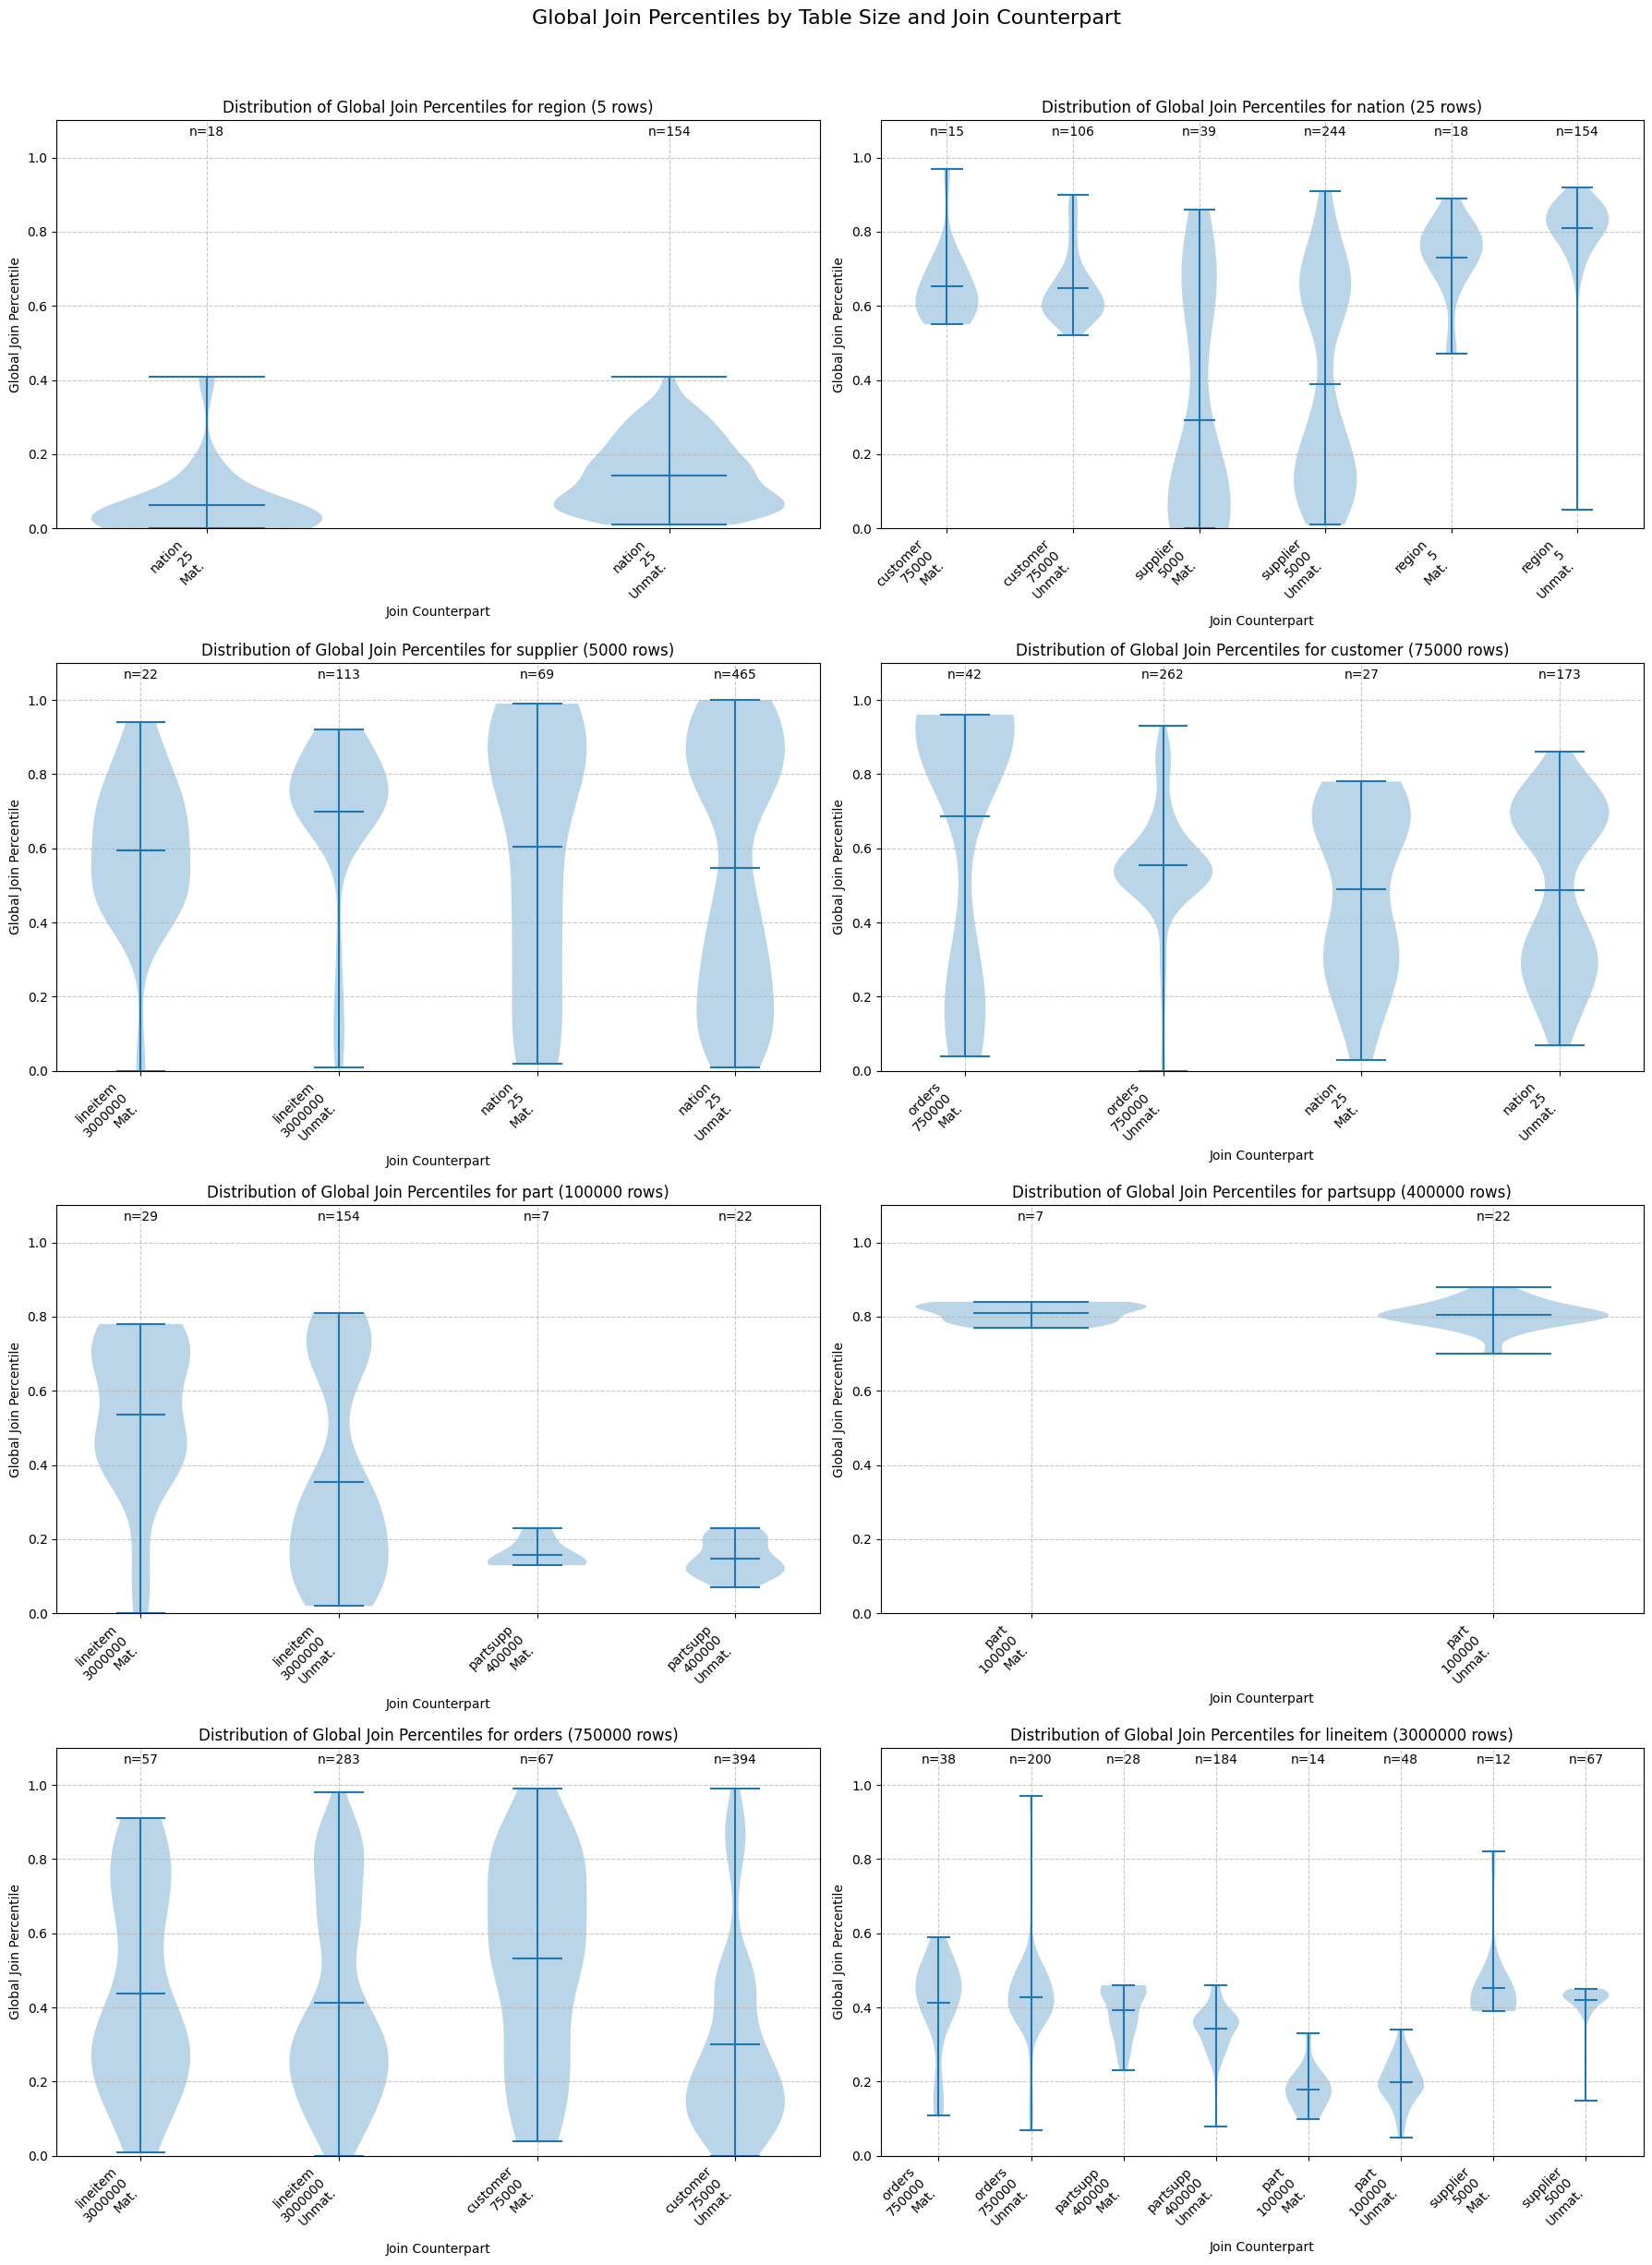

In [1806]:
# Sort the dataframe by improvement
single_join_df.sort_values("Improvement", ascending=False, inplace=True)

# Create figures with subplots
fig1, axes1 = plt.subplots(4, 2, figsize=(18, 24))
fig2, axes2 = plt.subplots(4, 2, figsize=(18, 24))
axes1 = axes1.flatten()
axes2 = axes2.flatten()

# Table sizes and their labels
table_sizes = {
    5: 'region (5 rows)',
    25: 'nation (25 rows)', 
    5000: 'supplier (5000 rows)',
    75000: 'customer (75000 rows)',
    100000: 'part (100000 rows)',
    400000: 'partsupp (400000 rows)',
    750000: 'orders (750000 rows)',
    3000000: 'lineitem (3000000 rows)'
}

# Create violin plots for each table size
for idx, (size, label) in enumerate(table_sizes.items()):
        # For Query Join Percentile
    data1 = []
        # For Global Join Percentile  
    data2 = []
    labels = []
    
    # Get data for current table size
    df_subset = single_join_df[single_join_df['Table size'] == size]
    
    # Group by counterpart table
    for cp_name, cp_size in df_subset[['Join Counterpart Table Name', 'Join Counterpart Table Size']].drop_duplicates().sort_values('Join Counterpart Table Size', ascending=False).values:
        if pd.isna(cp_name):
            continue
            
        # Get data for materialized counterpart
        mat_data = df_subset[
            (df_subset['Join Counterpart Table Name'] == cp_name) & 
            (df_subset['Join Counterpart is materialized'] == True)
        ]
        
        # Get data for unmaterialized counterpart
        unmat_data = df_subset[
            (df_subset['Join Counterpart Table Name'] == cp_name) & 
            (df_subset['Join Counterpart is materialized'] == False)
        ]

        if len(mat_data) > 0:
            data1.append(mat_data['Query Join percentile'])
            data2.append(mat_data['Global Join percentile'])
            labels.append(f'{cp_name}\n{int(cp_size)}\nMat.')
        
        if len(unmat_data) > 0:
            data1.append(unmat_data['Query Join percentile'])
            data2.append(unmat_data['Global Join percentile'])
            labels.append(f'{cp_name}\n{int(cp_size)}\nUnmat.')
    
    # Only create violin plots if we have data
    if len(data1) > 0:
        # Query Join Percentile plot
        axes1[idx].set_ylim(0, 1.1)  # leave space for count annotations
        violin_plot1 = axes1[idx].violinplot(data1, showmeans=True)
        axes1[idx].set_xticks(range(1, len(data1) + 1))
        axes1[idx].set_xticklabels(labels, rotation=45, ha='right')
        axes1[idx].set_xlabel('Join Counterpart')
        axes1[idx].set_ylabel('Query Join Percentile')
        axes1[idx].set_title(f'Distribution of Query Join Percentiles for {label}')
        axes1[idx].grid(True, linestyle='--', alpha=0.7)
        # Annotate counts
        for i, d in enumerate(data1):
            n = len(d)
            axes1[idx].text(i+1, 1.05, f'n={n}', ha='center', va='bottom')
        
        # Global Join Percentile plot
        axes2[idx].set_ylim(0, 1.1)
        violin_plot2 = axes2[idx].violinplot(data2, showmeans=True)
        axes2[idx].set_xticks(range(1, len(data2) + 1))
        axes2[idx].set_xticklabels(labels, rotation=45, ha='right')
        axes2[idx].set_xlabel('Join Counterpart')
        axes2[idx].set_ylabel('Global Join Percentile')
        axes2[idx].set_title(f'Distribution of Global Join Percentiles for {label}')
        axes2[idx].grid(True, linestyle='--', alpha=0.7)
        # Annotate counts
        for i, d in enumerate(data2):
            n = len(d)
            axes2[idx].text(i+1, 1.05, f'n={n}', ha='center', va='bottom')
    else:
        axes1[idx].text(0.5, 0.5, 'No data available', 
                          horizontalalignment='center',
                          verticalalignment='center')
        axes1[idx].set_title(f'Distribution of Query Join Percentiles for {label}')
        axes1[idx].set_ylim(0, 1)
        
        axes2[idx].text(0.5, 0.5, 'No data available',
                          horizontalalignment='center', 
                          verticalalignment='center')
        axes2[idx].set_title(f'Distribution of Global Join Percentiles for {label}')
        axes2[idx].set_ylim(0, 1)

fig1.suptitle('Query Join Percentiles by Table Size and Join Counterpart', y=1.02, fontsize=16)
fig2.suptitle('Global Join Percentiles by Table Size and Join Counterpart', y=1.02, fontsize=16)
fig1.tight_layout()
fig2.tight_layout()


In [1807]:
# Get data for single where clauses and calculate percentiles
single_wheres = results_df[(results_df["Total Frequency"] == 1) & (results_df["Where Frequency"] == 1)].copy()

# Calculate query percentile for single where clauses
single_wheres['Query Where Percentile'] = single_wheres.groupby('Query')['Improvement'].rank(pct=True)

# Calculate global percentile across all single where clauses
single_wheres['Global Where Percentile'] = single_wheres['Improvement'].rank(pct=True)

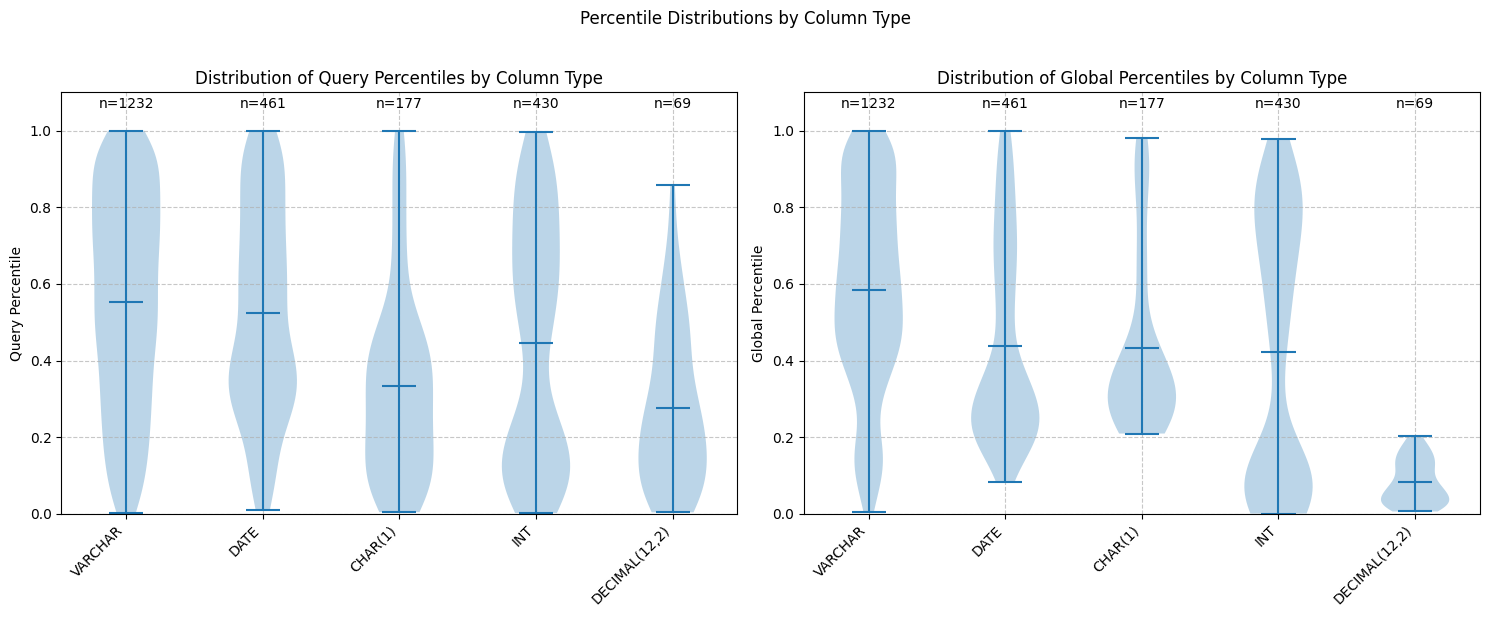

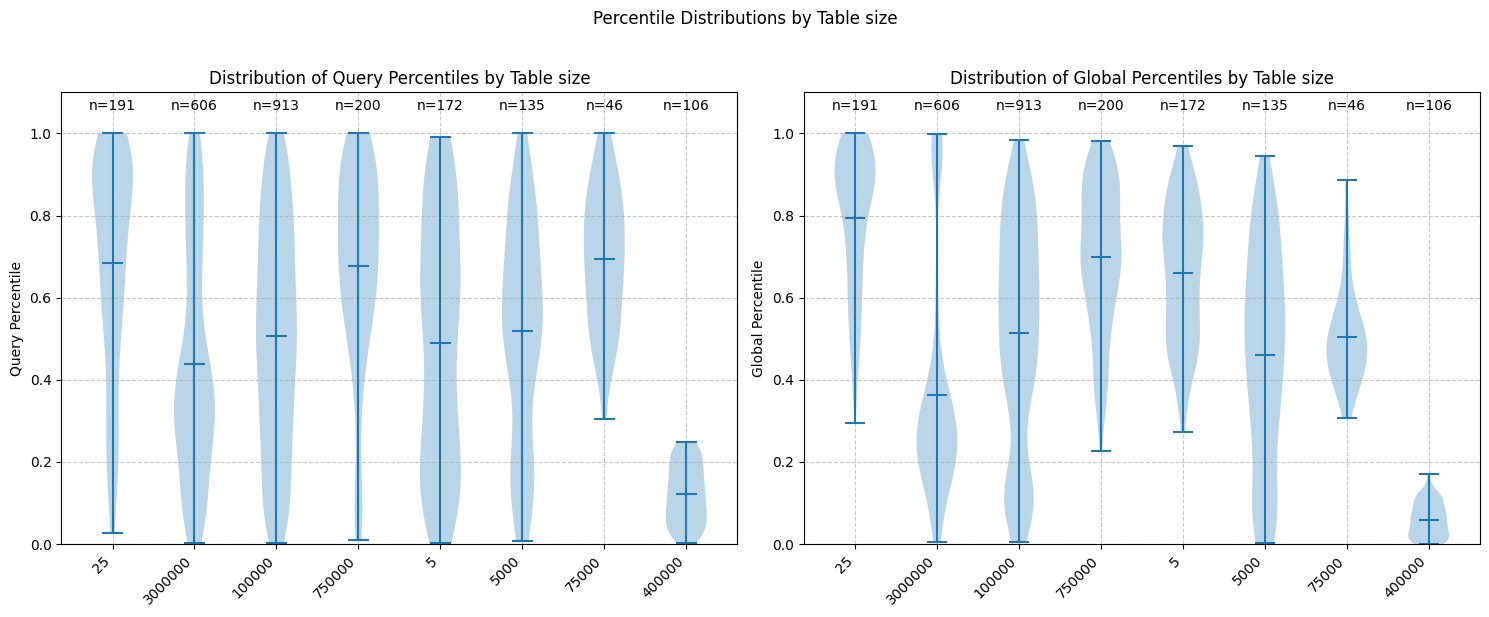

In [1808]:


# Create figures and axes for all plots
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig2, (ax3, ax4) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for Query Percentile by Column Type
data1 = [single_wheres[single_wheres['Column Type'] == ct]['Query Where Percentile'].values 
         for ct in single_wheres['Column Type'].unique()]
labels1 = single_wheres['Column Type'].unique()

violin1 = ax1.violinplot(data1, showmeans=True)
ax1.set_xticks(range(1, len(labels1) + 1))
ax1.set_xticklabels(labels1, rotation=45, ha='right')
ax1.set_ylabel('Query Percentile')
ax1.set_title('Distribution of Query Percentiles by Column Type')
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.set_ylim(0, 1.1)

# Annotate counts
for i, d in enumerate(data1):
    n = len(d)
    ax1.text(i+1, 1.05, f'n={n}', ha='center', va='bottom')

# Plot for Global Percentile by Column Type
data2 = [single_wheres[single_wheres['Column Type'] == ct]['Global Where Percentile'].values 
         for ct in single_wheres['Column Type'].unique()]

violin2 = ax2.violinplot(data2, showmeans=True)
ax2.set_xticks(range(1, len(labels1) + 1))
ax2.set_xticklabels(labels1, rotation=45, ha='right')
ax2.set_ylabel('Global Percentile')
ax2.set_title('Distribution of Global Percentiles by Column Type')
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.set_ylim(0, 1.1)

# Annotate counts
for i, d in enumerate(data2):
    n = len(d)
    ax2.text(i+1, 1.05, f'n={n}', ha='center', va='bottom')

# Plot for Query Percentile by Table Size
data3 = [single_wheres[single_wheres['Table size'] == ts]['Query Where Percentile'].values 
         for ts in single_wheres['Table size'].unique()]
labels2 = single_wheres['Table size'].unique()

violin3 = ax3.violinplot(data3, showmeans=True)
ax3.set_xticks(range(1, len(labels2) + 1))
ax3.set_xticklabels(labels2, rotation=45, ha='right')
ax3.set_ylabel('Query Percentile')
ax3.set_title('Distribution of Query Percentiles by Table size')
ax3.grid(True, linestyle='--', alpha=0.7)
ax3.set_ylim(0, 1.1)

# Annotate counts
for i, d in enumerate(data3):
    n = len(d)
    ax3.text(i+1, 1.05, f'n={n}', ha='center', va='bottom')

# Plot for Global Percentile by Table size
data4 = [single_wheres[single_wheres['Table size'] == ts]['Global Where Percentile'].values 
         for ts in single_wheres['Table size'].unique()]

violin4 = ax4.violinplot(data4, showmeans=True)
ax4.set_xticks(range(1, len(labels2) + 1))
ax4.set_xticklabels(labels2, rotation=45, ha='right')
ax4.set_ylabel('Global Percentile')
ax4.set_title('Distribution of Global Percentiles by Table size')
ax4.grid(True, linestyle='--', alpha=0.7)
ax4.set_ylim(0, 1.1)

# Annotate counts
for i, d in enumerate(data4):
    n = len(d)
    ax4.text(i+1, 1.05, f'n={n}', ha='center', va='bottom')

fig1.suptitle('Percentile Distributions by Column Type', y=1.02)
fig2.suptitle('Percentile Distributions by Table size', y=1.02)
fig1.tight_layout()
fig2.tight_layout()
plt.show()